In [214]:
import pandas as pd
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from collections import namedtuple
from datetime import datetime, timedelta
import numpy as np
import warnings;
warnings.filterwarnings('ignore');
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
%matplotlib inline
import re
import time
import operator

# Introduction
The aim of our project is to try to help people become more aware of what they consume.  In order to do this, the first thing we have to do is to inform ourselves about the current situation of consumption in Europe.
Once we know the current situation, we are more prepared to realize our goal: to discover hidden information in how we eat. This information can be discovered by making an analysis of the correlation between different foods.
These results can contribute to make people more aware of what they eat, and therefore, have more tools to take care of their food.

In this notebook, we will focus in analyzing several consumption trends in Europe, for example, to check if the population eats healthy or not, and if it follows the medical recommendations, for example the famous food pyramid.
We feel like it is important to do an analysis of how and what the population consumes before delivering a tool to help people eat healthier. 

# Structure of the notebook 

- A) Analysis of dataset "EFSA Comprehensive European Food Consumption Database"
- B) Analysis of dataset "Recipe1M+"
- Conclusion and next steps

# A) Analysis of dataset "EFSA Comprehensive European Food Consumption Database"

**Table of content:**

- 1) Dataset Analysis: Check how the data is structured.
- 2) Plot in time of the consumption of Alcohol in Spain
- 3) Plot in time of the consumption of Alcohol for chunks
- 4) Plot in time the healthy and unhealthy products consumption in Spain
- 5) Compare the recommended food pyramid with the real consumption in spain


## 1) Dataset Analysis: Check how the data is structured.

As the dataset is structured in surveys, we want to do a Gantt chart to visualize when and where the surveys took place, before conducting further analysis of the data

In [215]:
df = pd.read_csv("ESFA/survey_details/survey.csv", encoding="utf_16_le")

In [216]:
df.head()

,Country DESC,Start Year ID,Survey DESC,CODE,Reference publication,Consecutive replicates,Replicates,Interview meetings,Response rate (%),Min age range (years),...,Survey period,Age range (year),Survey Comment,Survey start,Survey end,Sampling method,Sample unit,Over sampled,Dietary software,Method under-reporters
0,Austria,2005.0,Austrian Study on Nutritional Status 2005-06,ASNS,"Elmadfa I, Freisling H, Nowak V and Hofstädter...",NaN,1,NaN,48.0,19.0,...,5-06-01 / 6-06-01,19 - 65,NaN,6/1/2005,6/1/2006,"Random from telephone book, Job centres, gynae...",Individuals,NaN,NaN,NaN
1,Austria,2010.0,Austrian Study on Nutritional Status 2010-12 -...,ASNS - ADULTS,Elmadfa I et al. Österreichischer Ernährungsbe...,10.0,2,1.0,65.0,18.0,...,0-08-15 / 2-02-15,18 - 80,NaN,8/15/2010,2/15/2012,"Quota, Austrian standard population from Censu...",Individuals,NaN,Nutritional software,Schofield cut off 0.81
2,Austria,2010.0,Austrian Study on Nutritional Status 2010-12 -...,ASNS - CHILDREN,Elmadfa I et al. Österreichischer Ernährungsbe...,NaN,3,1.0,50.0,6.0,...,0-08-15 / 2-02-15,6 - 15,NaN,8/15/2010,2/15/2012,"Quota, Austrian standard population from Censu...",Individuals,NaN,Nutritional software,Cut off 0.76
3,Belgium,2002.0,Regional Flanders,REGIONAL FLANDERS,"Huybrechts I, Matthys C, Pynaert I, De Maeyer ...",NaN,3,NaN,NaN,2.5,...,2-01-01 / 2-12-31,2.5 - 6.5,NaN,1/1/2002,12/31/2002,NaN,NaN,NaN,NaN,NaN
4,Belgium,2004.0,Diet National 2004,DIET NATIONAL 2004,"De Vriese S, Huybrecht I, Moreau M, De Henauw ...",NaN,2,NaN,41.0,15.0,...,4-01-01 / 4-12-31,15 -,NaN,1/1/2004,12/31/2004,Random from the national population register,Individuals,NaN,NaN,NaN


We will use the library `plotly` in order to plot the Gantt chart. We therefore select the necessary columns and we assign the right names, as requested by the library:

In [217]:
df_gantt = (
    df[["Country DESC", "Survey DESC", "Survey start", "Survey end"]]
    .rename(columns={
        "Country DESC":"Task",
        "Survey DESC":"Survey",
        "Survey start":"Start",
        "Survey end":"Finish"})
)
df_gantt.head()

,Task,Survey,Start,Finish
0,Austria,Austrian Study on Nutritional Status 2005-06,6/1/2005,6/1/2006
1,Austria,Austrian Study on Nutritional Status 2010-12 -...,8/15/2010,2/15/2012
2,Austria,Austrian Study on Nutritional Status 2010-12 -...,8/15/2010,2/15/2012
3,Belgium,Regional Flanders,1/1/2002,12/31/2002
4,Belgium,Diet National 2004,1/1/2004,12/31/2004


We fill in missing values:

In [218]:
df_gantt["Finish"][32] = "2/1/2014"
df_gantt["Start"][45] = "01/01/2014"
df_gantt["Finish"][45] = "01/01/2014"

We transform dates into python dates:

In [219]:
from dateutil import parser

df_gantt["Start"] = df_gantt["Start"].map(lambda x : parser.parse(x))
df_gantt["Finish"] = df_gantt["Finish"].map(lambda x : parser.parse(x))

We filter out nations for which we only have one survey (or multiple surveys done the same year):

In [220]:
df_gantt = (
    df_gantt
    .drop_duplicates()
    .groupby("Task")
    .filter(lambda x : len(x) > 1)
    .reset_index(drop=True)
)

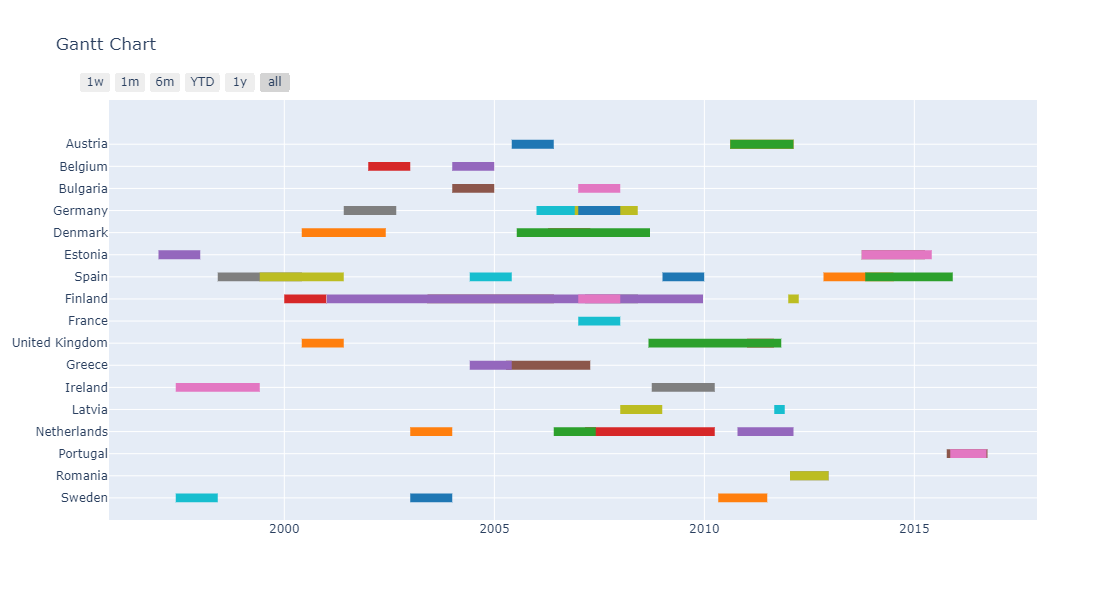

In [221]:
fig = ff.create_gantt(df_gantt, group_tasks=True, showgrid_x=True, showgrid_y=True)
fig.show()

We notice that we don't have all these surveys in the Chronic Food consumption dataset downloaded by the visualization tool (eg the Estonia 1997 survey is missing), therefore we will use the full dataset.

We can't compare all nations in the dataset, as many nations only have one survey or they don't have surveys spanning over an enough large time chunk. So we restrict the analysis to nations for which we can compare behaviours between distant points in time.

Most promising nations are:
- Estonia
- Spain
- Finland
- UK
- Ireland
- Netherlands
- Sweden

Let's plot a Gantt with only these:

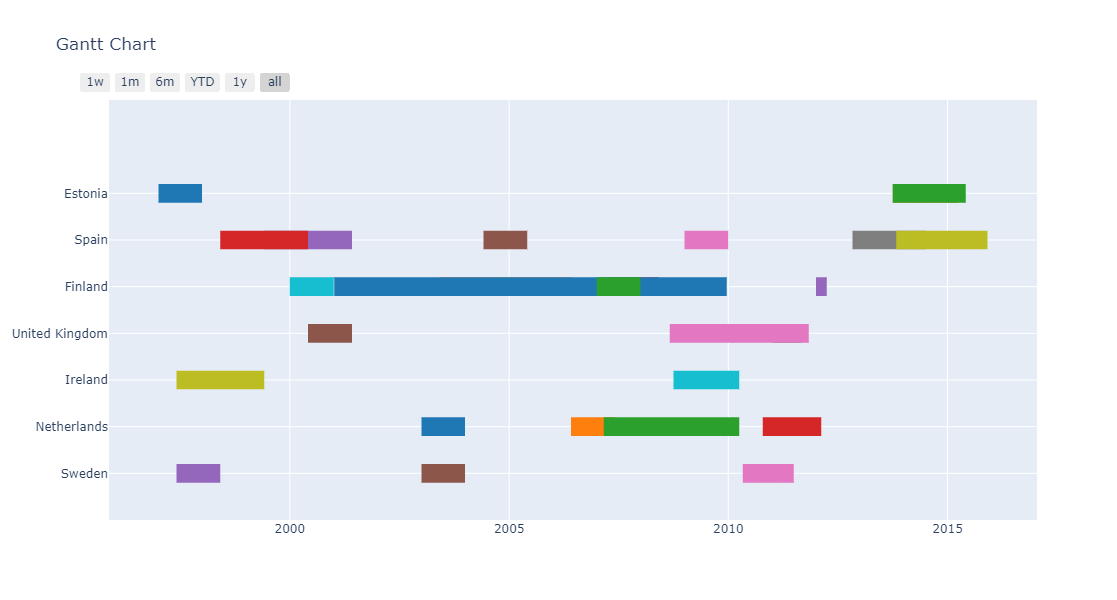

In [222]:
df_gantt_best = (
    df_gantt[df_gantt["Task"].isin(["Estonia","Spain","Finland","United Kingdom","Ireland","Netherlands","Sweden"])]
    .reset_index(drop=True)
)

fig = ff.create_gantt(df_gantt_best, group_tasks=True, showgrid_x=True, showgrid_y=True)
fig.show()

We remove Finland long survey

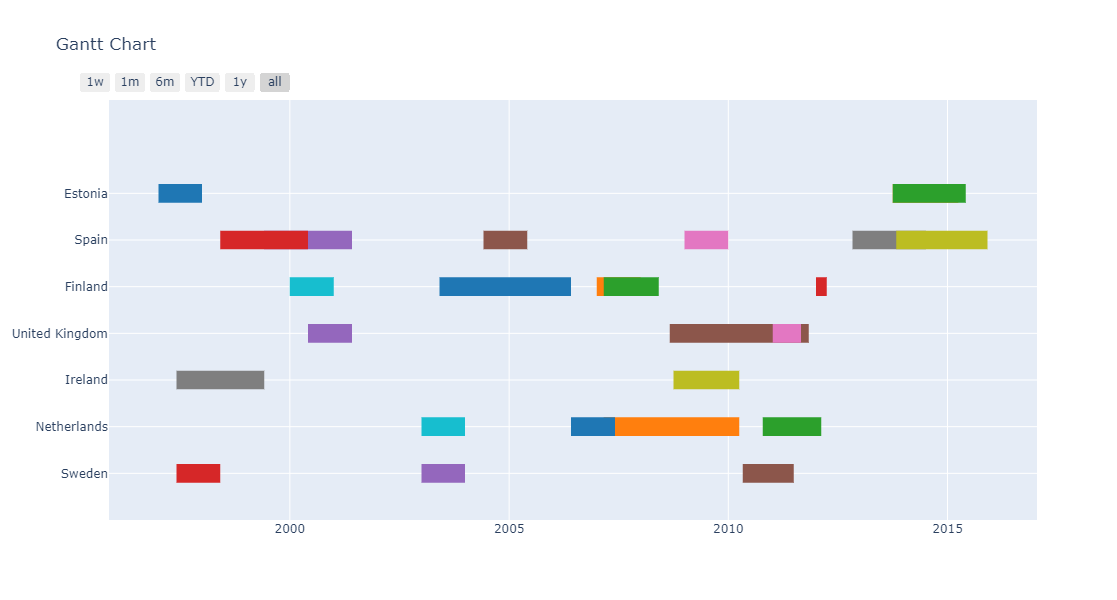

In [223]:
df_gantt_best = (
    df_gantt_best[
        ~(
            (df_gantt_best["Start"] == parser.parse("2001-01-04")) &
            (df_gantt_best["Finish"] == parser.parse("2009-12-19"))
        )]
    .reset_index(drop=True)
)

fig = ff.create_gantt(df_gantt_best, group_tasks=True, showgrid_x=True, showgrid_y=True)
fig.show()

At this point, we try dividing surveys in chunks, in order to be able to make comparisons on the average over all the nations selected.

We define the following chunks:

- 1997 - 2001
- 2003 - 2007
- 2008 - 2012
- 2012 - 2015

In [224]:
df_surveys = (
    df_gantt_best
    .copy()
    .rename(columns = {
        "Task":"Country",
        "Finish":"End"
    })
)

df_surveys.head()

,Country,Survey,Start,End
0,Estonia,National Dietary Survey 1997,1997-01-01,1997-12-31
1,Estonia,National Dietary Survey among 11-74 years old ...,2013-10-01,2015-04-01
2,Estonia,National Dietary Survey among children up to t...,2013-10-01,2015-06-01
3,Spain,Food patterns of Spanish schoolchildren and ad...,1998-06-01,2000-06-01
4,Spain,Spanish Agency for Food Safety (AESAN) Survey,1999-06-01,2001-06-01


In [225]:
DateRange = namedtuple("DateRange", ["start","end"])

def get_date_range(start, end):
    return DateRange(start=datetime(start,1,1), end=datetime(end,12,31))

def assign_chunk(row):
    #print("Start: {}, type: {}".format(row["Start"], type(row["Start"])))
    #print("End: {}".format(row["Start"]))
    survey_range = DateRange(start=row["Start"].to_pydatetime(), end=row["End"].to_pydatetime())
    best_chunk = 0
    max_overlap = timedelta()
    for i,chunk in enumerate(chunks):
        max_start = max(chunk.start, survey_range.start)
        min_end = min(chunk.end, survey_range.end)
        overlap = (min_end - max_start)
        if overlap > max_overlap:
            max_overlap = overlap
            best_chunk = i
    return best_chunk

In [226]:
chunks = [
    get_date_range(1997, 2001),
    get_date_range(2003, 2007),
    get_date_range(2008, 2011),
    get_date_range(2012, 2015)
]

df_surveys["chunk"] = df_surveys.apply(assign_chunk, axis=1)
df_surveys.sort_values("Start", inplace=True)
df_surveys.head(9)

,Country,Survey,Start,End,chunk
0,Estonia,National Dietary Survey 1997,1997-01-01,1997-12-31,0
23,Sweden,Swedish National Dietary Survey - RIKSMATEN 19...,1997-06-01,1998-06-01,0
17,Ireland,North/South Ireland Food Consumption Survey,1997-06-01,1999-06-01,0
3,Spain,Food patterns of Spanish schoolchildren and ad...,1998-06-01,2000-06-01,0
4,Spain,Spanish Agency for Food Safety (AESAN) Survey,1999-06-01,2001-06-01,0
9,Finland,Special Turku Coronary Risk Factor Interventio...,2000-01-01,2000-12-31,0
14,United Kingdom,National Diet and Nutrition Survey,2000-06-01,2001-06-01,0
19,Netherlands,Dutch National Dietary Survey 2003,2003-01-01,2003-12-31,1
24,Sweden,National Food Administration,2003-01-01,2003-12-31,1


We save dataframe to file as later we will use this data for further analysis

In [227]:
df_surveys.to_csv(r"ESFA/surveys_chunks.csv")

Our results with designated chunks are not very meaningful (we miss data), let's try with just two chunks:

In [228]:
chunks = [
    get_date_range(1997, 2006),
    get_date_range(2007, 2015)
]

df_surveys["chunk"] = df_surveys.apply(assign_chunk, axis=1)
df_surveys.sort_values("Start", inplace=True)

We save the chunks, as the results are more meaningful

In [229]:
df_surveys.to_csv(r"ESFA/surveys_chunks_2.csv")

In [230]:
df = pd.read_csv("ESFA/dataset.csv", sep='\t', encoding = "unicode_escape", low_memory=False)

We proceed to do a change of columns name to make it more clear

In [231]:
col_ren = {"SurveyscountryDESC" : "survey_country",
           "SurveystartyearID" : "survey_start_year",
           "SurveyDESC": "survey_desc",
           "SurveyID": "Survey_ID",
           "PopulationGroupL2DESC": "pop_group",
           "ExposurehierarchyL1DESC": "food_type_L1",
           "ExposurehierarchyL2DESC": "food_type_L2",
           "ExposurehierarchyL3DESC": "food_type_L3",
           "ExposurehierarchyL4DESC": "food_type_L4",
           "ExposurehierarchyL7DESC" : "food_type_L7",
           "count_subject_s_pg": "pop_count",
           "count_subject_wg": "cons_count",
           "avg_chronic_bw": "mean_weight",
           "avg_chronic": "avg_chronic",
           "count_days_wg": "count_days_wg",
           "count_days_s_pg":"count_days_s_pg",
           "STD_CH_BW": "std_weight",
           "median_chronic_bw": "med_weight"}

df_sel = df[list(col_ren.keys())].rename(columns=col_ren)

The fields that are more relevant are:
- <strong>survey_country: </strong> Country where the survey was conducted.
- <strong>survey_desc: </strong>Name of the survey.
- <strong>pop_group: </strong>Type of population group, per e.g. Adults or Adolescents.
- <strong>food_type_X : </strong>The different types of food, being X the level of specificity of the grouping.
- <strong>mean_weight: </strong>Is the mean of the grams of product consumed per day and per Kg of body weight of the people polled.
- <strong>avg_chronic: </strong>Is the mean of the grams of product consumed per day of the people polled.

Once we know the how the dataset is organized we will obtain some information about consumption trends.
In most of the cases we will use Spain, because as it can be seen it is the country that has the highest number of surveys, therefore more meaningful data.

---
## 2) Plot in time of the consumption of Alcohol in Spain
We are going to do a bottom-up aproach. First we are going to start with the consumption of a specific category and then broaden the analysis.
We start the analysis of an unhealthy food, in this case a beverage, starting with a single country, Spain.

<br />

In [232]:
df_spain = df_sel[df_sel["survey_country"] == "Spain"]
df_spain.head(4)

,survey_country,survey_start_year,survey_desc,Survey_ID,pop_group,food_type_L1,food_type_L2,food_type_L3,food_type_L4,food_type_L7,pop_count,cons_count,mean_weight,avg_chronic,count_days_wg,count_days_s_pg,std_weight,med_weight
59137,Spain,1998.0,Food patterns of Spanish schoolchildren and ad...,34,Toddlers,Animal and vegetable fats and oils and primary...,Animal and vegetable fats/oils,"Vegetable fats and oils, edible",Olive oils,Olive oils,17,10,0.729913,10.250000,16,34,0.625989,0.511739
59138,Spain,1998.0,Food patterns of Spanish schoolchildren and ad...,34,Toddlers,Animal and vegetable fats and oils and primary...,Animal and vegetable fats/oils,"Vegetable fats and oils, edible",Olive oils,"Olive oil, virgin or extra-virgin",17,3,0.257095,4.166667,3,34,0.183944,0.166667
59139,Spain,1998.0,Food patterns of Spanish schoolchildren and ad...,34,Toddlers,Animal and vegetable fats and oils and primary...,Animal and vegetable fats/oils,"Vegetable fats and oils, edible",Seed oils,"Sunflower seed oil, edible",17,4,0.572327,8.750000,6,34,0.170323,0.637175
59140,Spain,1998.0,Food patterns of Spanish schoolchildren and ad...,34,Toddlers,Animal and vegetable fats and oils and primary...,Fat emulsions and blended fats,Butter,Butter,Butter,17,2,0.173478,2.500000,2,34,0.012734,0.173478


$\large \sum_{food\_type, year} \frac{mean\_weight \cdot cons\_count}{pop\_count}$

In [233]:
df_spain_alcohol = df_spain[df_spain["food_type_L1"] == "Alcoholic beverages"].copy()
df_spain_alcohol["weight"] = df_spain_alcohol["mean_weight"] * df_spain_alcohol["cons_count"]
df_spain_alcohol["w_weight"] = df_spain_alcohol["weight"] / df_spain_alcohol["pop_count"]

df_spain_alcohol.head(4)

,survey_country,survey_start_year,survey_desc,Survey_ID,pop_group,food_type_L1,food_type_L2,food_type_L3,food_type_L4,food_type_L7,pop_count,cons_count,mean_weight,avg_chronic,count_days_wg,count_days_s_pg,std_weight,med_weight,weight,w_weight
59244,Spain,1998.0,Food patterns of Spanish schoolchildren and ad...,34,Other children,Alcoholic beverages,Wine and wine-like drinks,Wine,"Wine, white","Wine, white",156,2,0.302507,7.500000,2,312,0.217361,0.302507,0.605014,0.003878
59474,Spain,1998.0,Food patterns of Spanish schoolchildren and ad...,34,Adolescents,Alcoholic beverages,Wine and wine-like drinks,Wine,"Wine, red","Wine, red",209,1,0.140449,5.000000,1,418,0.000000,0.140449,0.140449,0.000672
59475,Spain,1998.0,Food patterns of Spanish schoolchildren and ad...,34,Adolescents,Alcoholic beverages,Wine and wine-like drinks,Wine,"Wine, white","Wine, white",209,1,0.096154,5.000000,1,418,0.000000,0.096154,0.096154,0.000460
59748,Spain,1999.0,Spanish Agency for Food Safety (AESAN) Survey,9,Adults,Alcoholic beverages,Beer and beer-like beverage,Beer,Beer,Beer,418,101,4.448947,330.836634,140,828,4.423882,2.774275,449.343657,1.074985


In [234]:
df_spain_alcohol_g = (
    df_spain_alcohol
    [["survey_start_year","pop_group","w_weight"]]
    .groupby(["survey_start_year","pop_group"])
    .sum()
    .rename(columns={"w_weight":"w_weight_sum"})
)
df_spain_alcohol_g

w_weight_sum
survey_start_year pop_group                   
1998.0            Adolescents         0.007925
                  Other children      0.027148
1999.0            Adults             10.968317
2004.0            Adolescents         1.284871
                  Other children      0.010965
2009.0            Adolescents         2.498153
                  Adults              7.846335
2013.0            Adults              7.612963
                  Elderly             9.948348

Now that we have the grams/day/kg of each group we are going to plot them to analyze the trend.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015E8FB69708>,
      dtype=object)

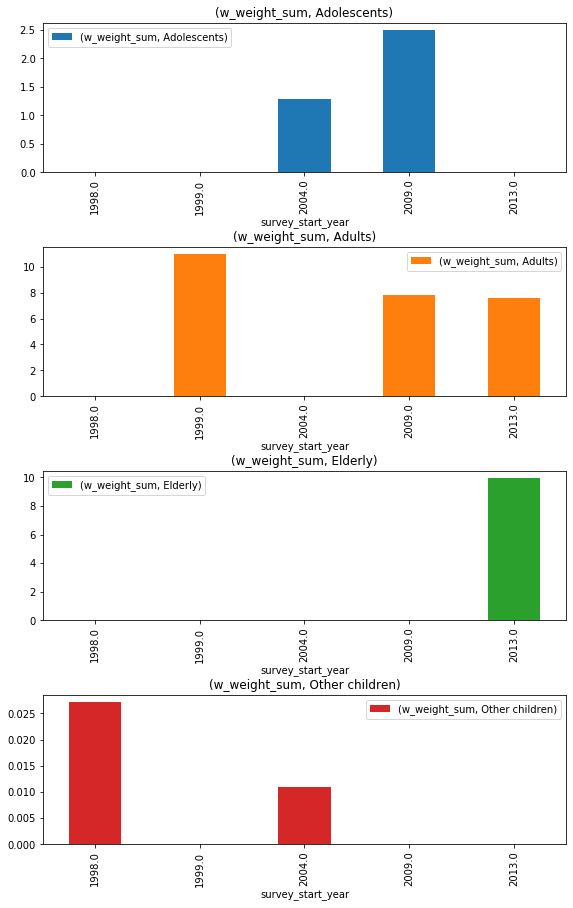

In [235]:
fig, axes = plt.subplots(4,1, figsize=(8,12))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)


df_spain_alcohol_g.unstack(level=1).plot(kind='bar', subplots=True, ax=axes[0])

We can see, that the consumption of alcohol in adolescents has increased, at the same time that it has decreased in smaller childrens (Other children). In adults the consumption is quite stable. Let's see if this results differ a lot when taking more countries into account.

---
## 3) Plot in time of the consumption of Alcohol for chunks

Now that we have analyzed the data in Spain, we will try to analyze it for Europe:

<br />

In [236]:
df_surveys_chunks = df = pd.read_csv(r"ESFA/surveys_chunks.csv", index_col=0)
df_surveys_chunks.head(4)

,Country,Survey,Start,End,chunk
0,Estonia,National Dietary Survey 1997,1997-01-01,1997-12-31,0
23,Sweden,Swedish National Dietary Survey - RIKSMATEN 19...,1997-06-01,1998-06-01,0
17,Ireland,North/South Ireland Food Consumption Survey,1997-06-01,1999-06-01,0
3,Spain,Food patterns of Spanish schoolchildren and ad...,1998-06-01,2000-06-01,0


In [237]:
df_alcohol = df_sel[df_sel["food_type_L1"] == "Alcoholic beverages"].copy()

In [238]:
df_alcohol_best = df_alcohol.merge(df_surveys_chunks[["Survey","chunk"]], left_on="survey_desc", right_on="Survey", how="inner")
df_alcohol_best.head(4)

,survey_country,survey_start_year,survey_desc,Survey_ID,pop_group,food_type_L1,food_type_L2,food_type_L3,food_type_L4,food_type_L7,pop_count,cons_count,mean_weight,avg_chronic,count_days_wg,count_days_s_pg,std_weight,med_weight,Survey,chunk
0,Estonia,1997.0,National Dietary Survey 1997,8,Adults,Alcoholic beverages,Beer and beer-like beverage,Beer,Lager beer,"Beer, regular",1866,206,13.698508,1074.029126,206,1866,11.860726,9.090909,National Dietary Survey 1997,0
1,Estonia,1997.0,National Dietary Survey 1997,8,Adults,Alcoholic beverages,Beer and beer-like beverage,Beer,Lager beer,"Beer, light",1866,1,4.714286,330.000000,1,1866,0.000000,4.714286,National Dietary Survey 1997,0
2,Estonia,1997.0,National Dietary Survey 1997,8,Adults,Alcoholic beverages,Beer and beer-like beverage,Beer-like beverages,Beer-like beverages,Beer-like beverages,1866,11,2.922928,211.390909,11,1866,1.856794,2.037662,National Dietary Survey 1997,0
3,Estonia,1997.0,National Dietary Survey 1997,8,Adults,Alcoholic beverages,Mixed alcoholic drinks,Cocktail drink,Cocktail drink,Cocktail drink,1866,3,4.251926,293.333333,3,1866,2.051787,4.925373,National Dietary Survey 1997,0


In [239]:
df_alcohol_best["survey_country"].unique()

array(['Estonia', 'Finland', 'Ireland', 'Netherlands', 'Spain', 'Sweden',
       'United Kingdom'], dtype=object)

These are the countries that we are going to take into account in the following analysis.

In [240]:
df_alcohol_best["weight"] = df_alcohol_best["mean_weight"] * df_alcohol_best["cons_count"]
df_alcohol_best["w_weight"] = df_alcohol_best["weight"] / df_alcohol_best["pop_count"]

In [241]:
df_alcohol_best_g = (
    df_alcohol_best
    [["chunk","pop_group","w_weight"]]
    .groupby(["chunk","pop_group"])
    .sum()
    .rename(columns={"w_weight":"w_weight_sum"})
)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015E8AD26E48>,
      dtype=object)

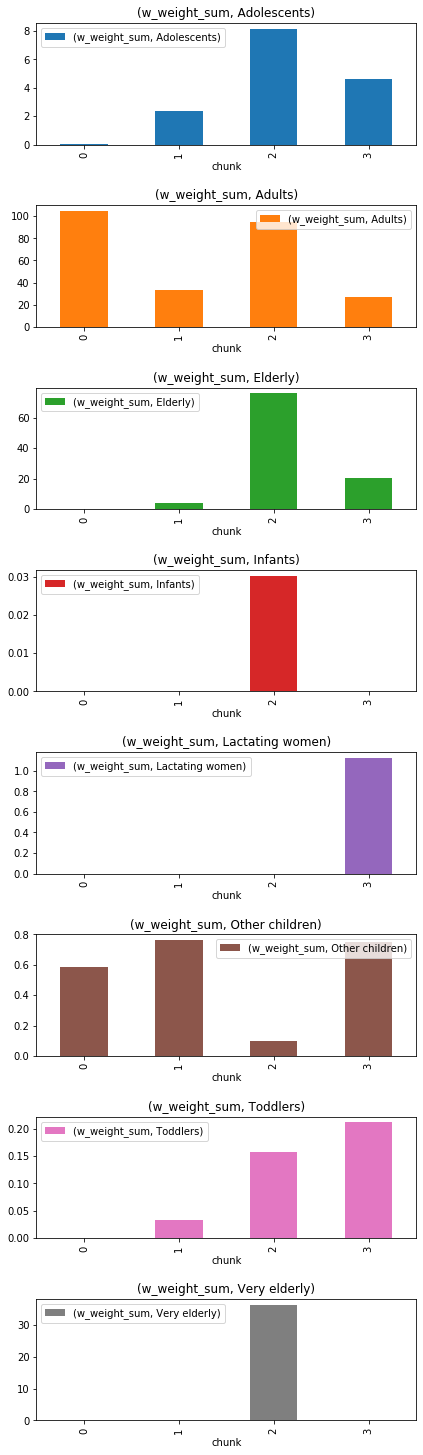

In [242]:
fig, axes = plt.subplots(8,1, figsize=(8,24))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)


df_alcohol_best_g.unstack(level=1).plot(kind='bar', subplots=True, ax=axes[0])

As can be seen, the results are quite striking. The difference between the chunks (and therefore periods of time) is too large. This is probably due to some chunks not having surveys at all.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015E80446AC8>,
      dtype=object)

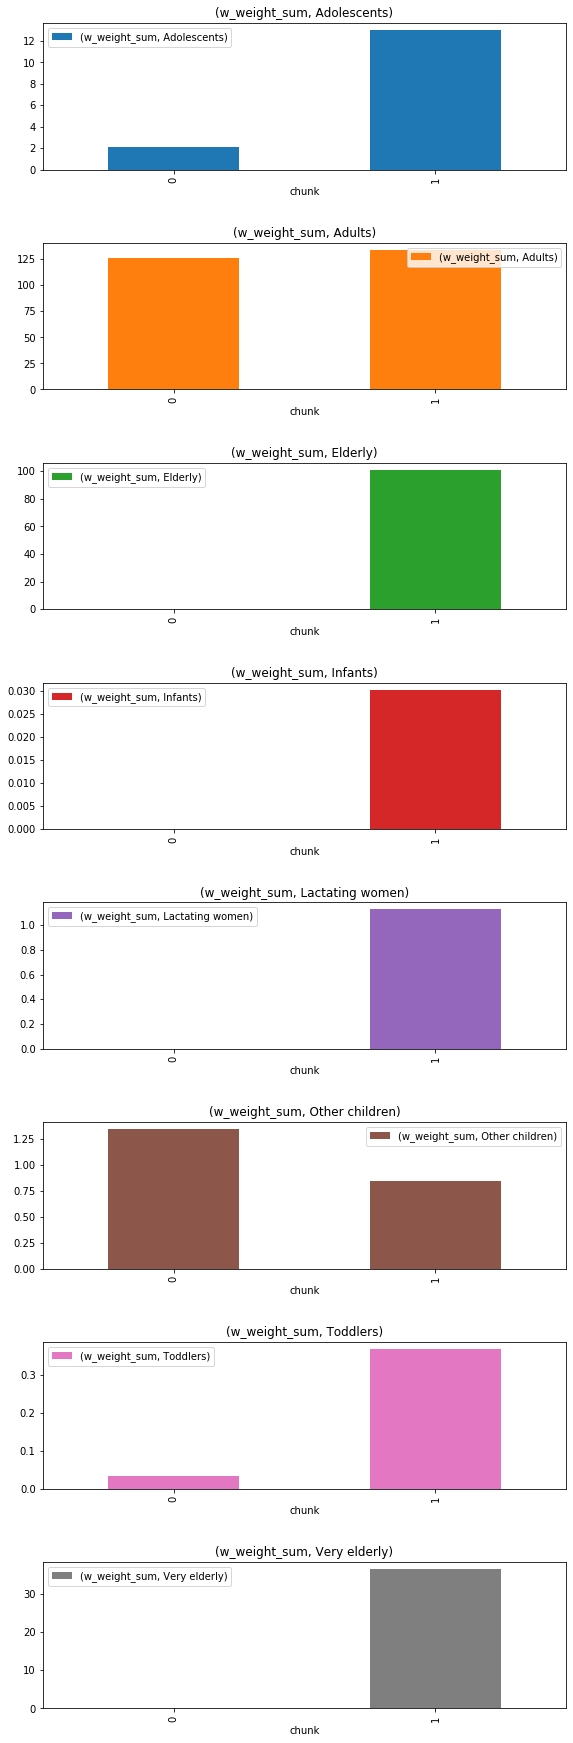

In [31]:
df_surveys_chunks = df = pd.read_csv(r"ESFA/surveys_chunks_2.csv", index_col=0)
df_alcohol = df_sel[df_sel["food_type_L1"] == "Alcoholic beverages"].copy()

df_alcohol_best = df_alcohol.merge(df_surveys_chunks[["Survey","chunk"]], left_on="survey_desc", right_on="Survey", how="inner")
df_alcohol_best["weight"] = df_alcohol_best["mean_weight"] * df_alcohol_best["cons_count"]
df_alcohol_best["w_weight"] = df_alcohol_best["weight"] / df_alcohol_best["pop_count"]

df_alcohol_best_g = (
    df_alcohol_best
    [["chunk","pop_group","w_weight"]]
    .groupby(["chunk","pop_group"])
    .sum()
    .rename(columns={"w_weight":"w_weight_sum"})
)

fig, axes = plt.subplots(8,1, figsize=(8,24))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)


df_alcohol_best_g.unstack(level=1).plot(kind='bar', subplots=True, ax=axes[0])

We see we probably don't have data for Elderly, Very Elderly, Infants and Lactating Women in the first chunk.

We can guess some trends with such data, but we realize it's probably not enough?

---
## 4) Plot in time the healthy and unhealthy products consumption in Spain

As alcoholic is only one type of unhealthy food, we will try to get two clear groups of healthy and unhealthy food to analyze its consumption:

<br />

In [32]:
#We obtain the names of the different surveys done in Spain
aux = df_sel[df_sel["survey_country"]=="Spain"]
aux[["survey_desc","Survey_ID","survey_start_year"]].drop_duplicates()

,survey_desc,Survey_ID,survey_start_year
59137,Food patterns of Spanish schoolchildren and ad...,34,1998.0
59748,Spanish Agency for Food Safety (AESAN) Survey,9,1999.0
60171,Encuesta de nutrición 2005,35,2004.0
60797,Spanish Agency for Food Safety (AESAN) - FIAB ...,10,2009.0
61479,Spanish National dietary survey on children an...,59,2012.0
62881,"Spanish National dietary survey in adults, eld...",62,2013.0


We create two arrays containing some healthy and unhealthy food.

In [33]:
healthyFood = ["Legumes","Fruit used as fruit","Vegetables and vegetable products","Hot drinks and similar (coffee, cocoa, tea and herbal infusions)","Leafy vegetables","Fruit and fruit products"]
unhealthyFood = ["Preserved/processed fat tissues","Artificial sweeteners (e.g., aspartam, saccharine)","Confectionery including chocolate","Spoonable desserts and ice creams (generic)"]


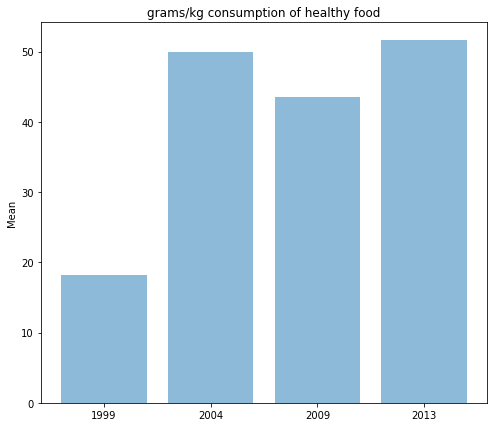

In [34]:
healthy1999= df_sel[(df_sel["food_type_L2"].isin(healthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==9)]
df_sel["healthy1999"] = healthy1999["mean_weight"]*healthy1999["cons_count"]/healthy1999["pop_count"]

healthy2004= df_sel[(df_sel["food_type_L2"].isin(healthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==35)]
df_sel["healthy2004"] = healthy2004["mean_weight"]*healthy2004["cons_count"]/healthy2004["pop_count"]

healthy2009= df_sel[(df_sel["food_type_L2"].isin(healthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==10)]
df_sel["healthy2009"] = healthy2009["mean_weight"]*healthy2009["cons_count"]/healthy2009["pop_count"]

healthy2013= df_sel[(df_sel["food_type_L2"].isin(healthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==62)]
df_sel["healthy2013"] = healthy2013["mean_weight"]*healthy2013["cons_count"]/healthy2013["pop_count"]

fig, ax = plt.subplots(figsize=(8, 7))
years = ["1999","2004","2009","2013"]
consumption = [df_sel["healthy1999"].sum(),df_sel["healthy2004"].sum(),df_sel["healthy2009"].sum(),df_sel["healthy2013"].sum()]
ax.bar(years,consumption , align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean')

ax.set_title('grams/kg consumption of healthy food')
plt.show(fig)

As we can see, in general the spanish population is eating healthier. Or at least, more of the aliments that we have considered healthy.

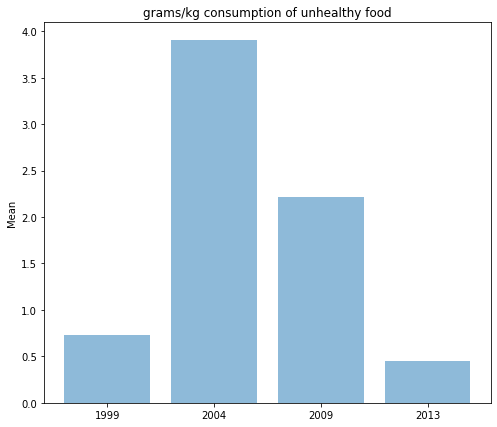

In [35]:
unhealthy1999= df_sel[(df_sel["food_type_L2"].isin(unhealthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==9)]
df_sel["unhealthy1999"] = unhealthy1999["mean_weight"]*unhealthy1999["cons_count"]/unhealthy1999["pop_count"]

unhealthy2004= df_sel[(df_sel["food_type_L2"].isin(unhealthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==35)]
df_sel["unhealthy2004"] = unhealthy2004["mean_weight"]*unhealthy2004["cons_count"]/unhealthy2004["pop_count"]

unhealthy2009= df_sel[(df_sel["food_type_L2"].isin(unhealthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==10)]
df_sel["unhealthy2009"] = unhealthy2009["mean_weight"]*unhealthy2009["cons_count"]/unhealthy2009["pop_count"]

unhealthy2013= df_sel[(df_sel["food_type_L2"].isin(unhealthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==62)]
df_sel["unhealthy2013"] = unhealthy2013["mean_weight"]*unhealthy2013["cons_count"]/unhealthy2013["pop_count"]

fig, ax = plt.subplots(figsize=(8, 7))
years = ["1999","2004","2009","2013"]
consumption = [df_sel["unhealthy1999"].sum(),df_sel["unhealthy2004"].sum(),df_sel["unhealthy2009"].sum(),df_sel["unhealthy2013"].sum()]
ax.bar(years,consumption , align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean')

ax.set_title('grams/kg consumption of unhealthy food')
plt.show(fig)

As can be seen, spanish population is reducing the amount of unhealthy food in general. However, this does not imply that spanish population is eating healthier, just less grams of unhealthy food, but the grams they consume can be more harmful. Therefore as this analysis is interesting but can be deceptive, we are going to use a more standard consumption measure, the food pyramid.

---
## 5) Compare the recommended food pyramid with the real consumption in spain

We are going to analyze if the spanish population follows the guidelines of food consumption. Specifically we are going to use the last large survey conducted in Spain, which was carried out from 2013 to 2015 and we are going to look at the consumption of the adult spanish population.
A really visual way of looking at the food consumtion is using the food pyramid, altought is not perfectly correct, is always informative to check for large deviations.
The guidelines of the food pyramid applied to the way our dataset is organized, FoodEx2 can be found in [FoodEx2 guidelines](https://susfans.eu/system/files/public_files/Publications/Reports/SUSFANS%20D2.2_V1.pdf)
The quantities que have choosen are either the Common set if available or the most conservative one between the rest of the options, usually czech republic.
The [reference pyramid](https://www.safefood.eu/Healthy-Eating/The-Food-Pyramid-and-The-Eatwell-Guide/The-Food-Pyramid.aspx) that we are going to use comes from a EU member, Ireland, to maintain consistency with the dataset.

<br />

In [138]:
#Let´s create the piramyd:
descriptions = ['Grains and grain-based products', 'Vegetables and vegetable products','Starchy roots or tubers and products thereof, sugar plants', 'Fruit and fruit products', 'Meat and meat products','Fish, seafood, amphibians, reptiles and invertebrates','Milk and dairy products', 'Eggs and egg products','Sugar and similar, confectionery and water-based sweet desserts','Animal and vegetable fats and oils and primary derivatives thereof','Fruit and vegetable juices and nectars (including concentrates)','Water and water-based beverages','Alcoholic beverages', 'Coffee, cocoa, tea and infusions',]
# Quantities at the web page, the values that are 0 will be analyzed later.
quantities = ['180','300','140','200','125','15','300','15','0','20','0','0','0','0']

#Gather the data from the dataset
df_sel['food_type_L7'].replace(' ', np.nan, inplace=True)
df_sel.dropna(subset=['food_type_L7'], inplace=True)

operations= df_sel[(df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==62)]
#df_sel["operations"] = operations["avg_chronic"]*operations["cons_count"]/operations["pop_count"]*operations["count_days_wg"]/operations["count_days_s_pg"]
df_sel["operations"] = operations["avg_chronic"]*operations["cons_count"]/operations["pop_count"]
df_prueba = (
    df_sel[(df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==62)]
    .groupby(["pop_group","food_type_L1"])
    .sum()
)
df_prueba = df_prueba.reset_index()

In [155]:
data = {'food_type_L1':descriptions, 'idealQuantities':quantities} 
dataFrameJoined = pd.DataFrame(data)
df_prueba = df_prueba[df_prueba["pop_group"]== "Adults"]
dataFrameJoined = dataPlot.merge(df_prueba[["food_type_L1","operations"]], left_on="food_type_L1", right_on="food_type_L1", how="inner")
quantitiesInt = list(map(int, quantities))
# We group the different FoodEx2 groups in the ones described in a typical food pyramid
# Vegetables+fruits, grains+starchy, milk related, meat+fish+eggs, fats
descriptionsOrdered = descriptions[1]+" and "+descriptions[3],descriptions[0]+" and "+descriptions[2],descriptions[6],descriptions[4]+", "+descriptions[5]+" and "+descriptions[7],descriptions[9]
quantitiesOrdered = quantitiesInt[1]+quantitiesInt[3],quantitiesInt[0]+quantitiesInt[2],quantitiesInt[6],quantitiesInt[4]+quantitiesInt[5]+quantitiesInt[7],quantitiesInt[9]

# dataPlotAsInt = dataPlotDef.astype({"idealQuantities": int, "operations": int})
indexOperations = dataFrameJoined.columns.get_loc("operations")
listRealConsum = []
listRealConsum.append(dataFrameJoined.iloc[[1,3],indexOperations].sum())
listRealConsum.append(dataFrameJoined.iloc[[0,2],indexOperations].sum())
listRealConsum.append(dataFrameJoined.iloc[[6],indexOperations].sum())
listRealConsum.append(dataFrameJoined.iloc[[4,5,7],indexOperations].sum())
listRealConsum.append(dataFrameJoined.iloc[[9],indexOperations].sum())
data = list(zip(descriptionsOrdered, quantitiesOrdered,listRealConsum))
dataFrameDef = pd.DataFrame(data,columns = ['Descriptions', 'Ideal Consumption','Real Consumption'])



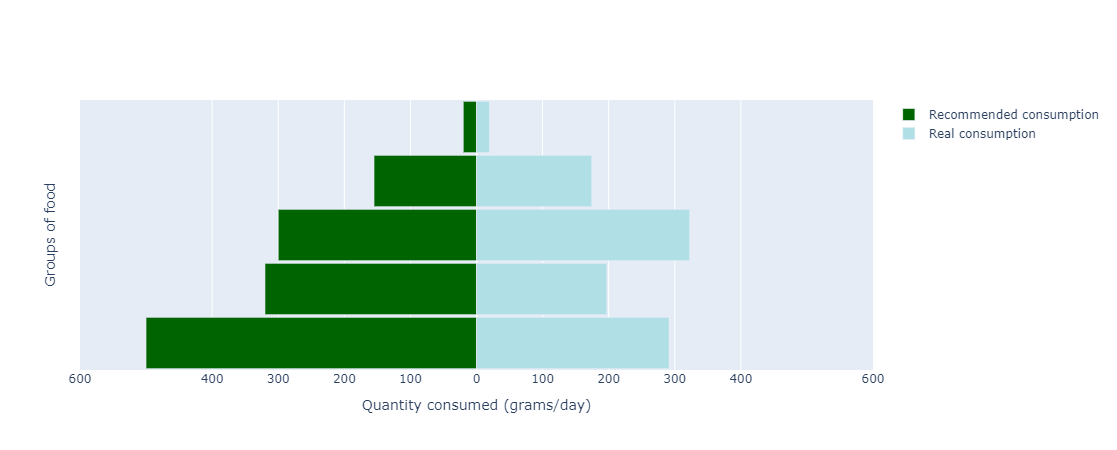

In [156]:
# Let's plot the food pyramid
y = dataFrameDef["Descriptions"]
layout = go.Layout(yaxis=go.layout.YAxis(title='Groups of food'),
                   xaxis=go.layout.XAxis(
                       range=[-600, 600],
                       tickvals=[-600 ,-400,-300, -200, -100, 0, 100, 200, 300, 400, 600],
                       ticktext=[600 ,400, 300, 200, 100, 0, 100, 200, 300, 400, 600],
                       title='Quantity consumed (grams/day)'),
                   barmode='overlay',
                   bargap=0.05)

data = [go.Bar(y=y,
               x=-dataFrameDef["Ideal Consumption"],
               orientation='h',
               name='Recommended consumption',
               customdata = dataFrameDef["Descriptions"],
               text = dataFrameDef["Ideal Consumption"],
               hovertemplate = '%{customdata} <br>Recommended: %{text} grams/day <extra></extra>',
               marker=dict(color='darkgreen')
               ),
        go.Bar(y=y,
               x=dataFrameDef["Real Consumption"],
               orientation='h',
               hovertext=dataFrameDef["Real Consumption"],
               name='Real consumption',
               customdata = dataFrameDef["Descriptions"],
               text = dataFrameDef["Real Consumption"],
               hovertemplate = '%{customdata} <br>Consumed: %{text:.0f} grams/day<extra></extra>',
               marker=dict(color='powderblue')
               )]
fig = go.Figure(dict(data=data, layout=layout))
fig.update_yaxes(showticklabels=False)
fig.show()

As can be seen, the real pyramid is a little bit deviated from the recommended one. For example, the amount of vegetables consumed is almost half of the recommended. Also, the difference in the Grains based products is quite large. However, in general, the real pyramid resembles quite nice the ideal one.
Nonetheless, there are some types of food consumed that don't have a recommended consumption amount, as a result of them being unhealthy or unnecessary. In this group they have a maximum consumption amount. We are going to analyze them:

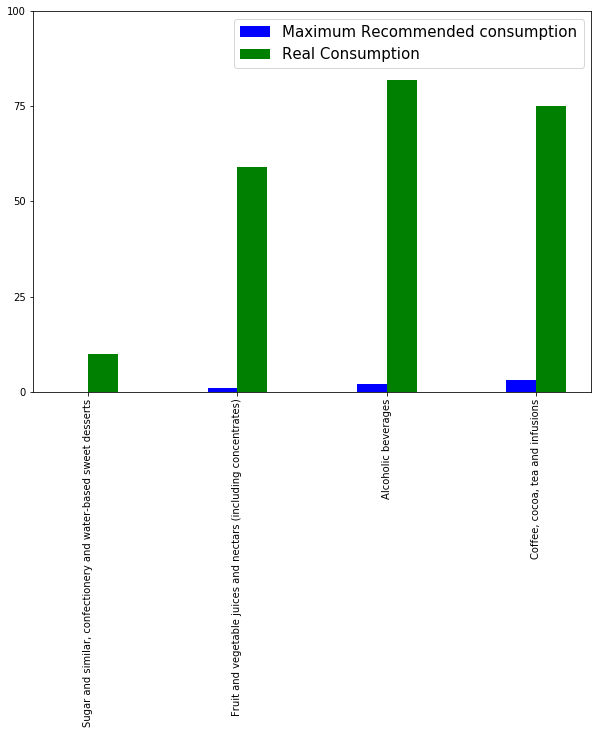

In [189]:
fig, ax = plt.subplots(figsize=(10, 7))
dataFrameMaxConsump = dataFrameJoined.iloc[[8,10,12,13],:]
# Sugar, juices, alcohol, infusions and coffee
maximumConsumption = ['71','200','10','300']

dataFrameMaxConsump["Maximum Consumption"] = maximumConsumption
dataFrameMaxConsump = dataFrameMaxConsump.astype({"operations": int})

_keys =  dataFrameMaxConsump["food_type_L1"]
_keys = list(_keys)
_data = dataFrameMaxConsump["Maximum Consumption"]
_data = list(_data)
_data2 = dataFrameMaxConsump["operations"]
_data2 = list(_data2)

ax.bar(np.arange(len(_keys))-0.1, _data, width=0.2, color='b', align='center', label="Maximum Recommended consumption")
ax.bar(np.arange(len(_keys))+0.1, _data2, width=0.2, color='g', align='center', label="Real Consumption")
ax.set_xticks(np.arange(len(_keys)))
ax.set_xticklabels(_keys)
ax.legend(prop={'size': 15})
plt.xticks(rotation=90)
plt.yticks([])
ax.set_yticks(np.arange(0, 125, step=25))
ax.set_yticklabels(np.arange(0, 125, step=25))

plt.show()

As can be seen, there is a lot of consumption of not so healthy things, that should not even be consumed. 

Now that we have finished the analysis of the actual consumption in an EU country, Spain in this case, we feel prepared to conduct further investigations to analyze the way we eat, and how it can affect us. We will analyze the different diets and their consequences to try to enlight the people a much as possible with our results, for them to make their decisions based on as much information as possible.

# B) Analysis of dataset "Recipe1M+"

This jupyter notebook corresponds to one part (out of two) of the final report for this milestone. In this notebook we work on the [recipies dataset](http://pic2recipe.csail.mit.edu). Here we will import the dataset, analyze it, search for missing data, clean it, filter it, and start the analysis to ensure that everything is ok for the final milestone. Before starting with all the mentioned tasks, we will present the idea and objectives of this part of the project.

Nowadays, huge advances in medicine and nutrition have led us to understand that the way we eat plays the most important role in our health. Following a diet rich in omega 6, for example, will lead us into different diseases, like cancer. Avoiding bad diets is “easily” achieved by eating a great variety of different food, while minimizing the amount of unhealthy meals. However, things can get harder when we have certain restrictions or obligations in our diet, for instance if we have to counter a lack of iron, or if we are vegan.

In this part of the project, we will use the `Recipe1M+` dataset to find the correlation between ingredients and see which ingredients are more likely to appear together in a recipe. This way, we will investigate how some restriction or obligations in our diets can affect undesired raises in specific aliments. 

These are some of the questions we want to answer in this project:

- What is the presence correlation between ingredients in recipes?
- Are there increases/decreases in the consumption of some ingredients when fighting against a specific disease via nutrition?
- Are there increases/decreases in the consumption of some ingredients when having restrictions in our diet?
- Which recipes are recommended to fight against a specific disease while not resulting in an undesirable increase of some other ingredients?
- Is it easier or harder for people with restrictions in their diets to eat "healthy"?
- Which type of meals (e.g. spicy) are more correlated with unhealthy food?
- More...

In this first approach, we will base our project in 5 specific nutritional situations, expanding it for the third milestone:

- Lactose intolerance
- Gluten intolerance
- Vegan diet
- Countering iron deficiency
- Countering omega 3 deficiency


## Table of contents

**1) Analysis and cleaning of the datasets:** In this part we import the data, look for missing or/and NaN values, clean the data, format it if needed and filter it.

**2) General analysis of the data:** Before going into the analysis we intend to do, we first do a more general analysis of the ingredients in recipes to obtain important information we will need for extracting the proper conclusions. In addition, in this part we will solve any unexpected errors encountered.

**3) Starting the core analysis:** In this part we will really start with the core project in order to see that everything is ok for the final report.

**4) Conclusions:** Important conclusions of the work done in this milestone.

In [6]:
# For beauty printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [7]:
# Main printing function
def printMain(to_print):
    print(color.BLUE + color.BOLD + to_print + color.END)

## 1) Analysis and cleaning of the datasets

In this first section we get the datasets into pandas and analyse the structure and the content of them. The we find and handle NaN and missing values, clean and format the data, and filter it to remove unnecesary features or items. Finally we adapt the data for the following analysis.

We have two datasets: `layer1.json` that has information about list of recipes, and `det_ingrs.json` with the ingredients of the recipes from the previous dataset in a cleaner way.

### Importing the data
First of all, let's import both datasets and analyse them.

In [8]:
# Importing layer1.json
initial_time = time.time()
df_recipes = pd.read_json('data/layer1.json')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("layer1.json dataset:")
df_recipes.head()

(Time: 29.54 seconds)
layer1.json dataset:


,ingredients,url,partition,title,id,instructions
0,"[{'text': '6 ounces penne'}, {'text': '2 cups ...",http://www.epicurious.com/recipes/food/views/-...,train,Worlds Best Mac and Cheese,000018c8a5,[{'text': 'Preheat the oven to 350 F. Butter o...
1,"[{'text': '1 c. elbow macaroni'}, {'text': '1 ...",http://cookeatshare.com/recipes/dilly-macaroni...,train,Dilly Macaroni Salad Recipe,000033e39b,[{'text': 'Cook macaroni according to package ...
2,"[{'text': '8 tomatoes, quartered'}, {'text': '...",http://www.foodnetwork.com/recipes/gazpacho1.html,train,Gazpacho,000035f7ed,[{'text': 'Add the tomatoes to a food processo...
3,"[{'text': '2 12 cups milk'}, {'text': '1 12 cu...",http://www.food.com/recipe/crunchy-onion-potat...,test,Crunchy Onion Potato Bake,00003a70b1,[{'text': 'Preheat oven to 350 degrees Fahrenh...
4,[{'text': '1 (3 ounce) package watermelon gela...,http://www.food.com/recipe/cool-n-easy-creamy-...,train,Cool 'n Easy Creamy Watermelon Pie,00004320bb,"[{'text': 'Dissolve Jello in boiling water.'},..."


In [9]:
# Importing det_ingrs.json
initial_time = time.time()
df_ingredients = pd.read_json('data/det_ingrs.json')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("det_ingrs.json dataset:")
df_ingredients.head()

(Time: 19.07 seconds)
det_ingrs.json dataset:


,valid,id,ingredients
0,"[True, True, True, True, True, True, True, Tru...",000018c8a5,"[{'text': 'penne'}, {'text': 'cheese sauce'}, ..."
1,"[True, True, True, True, True, True, True, Tru...",000033e39b,"[{'text': 'elbow macaroni'}, {'text': 'America..."
2,"[True, True, True, True, True, True, True, Tru...",000035f7ed,"[{'text': 'tomatoes'}, {'text': 'kosher salt'}..."
3,"[True, True, True, True, True, True, True]",00003a70b1,"[{'text': 'milk'}, {'text': 'water'}, {'text':..."
4,"[True, True, True, True, True]",00004320bb,"[{'text': 'watermelon gelatin'}, {'text': 'boi..."


We can see that the first dataset has no interesting information for our analysis so far. The title, url and instructions are not useful for us, and the ingredients will be taken from the `df_ingredients` as they are more clean, and so, easier to use. We delete the first dataframe.

In [10]:
# Deleting the first dataset
del df_recipes 

### Removing unnecessary data

In the `df_ingredients` we have 3 columns. The `ingredients` column is the most important one. `id` columns will be kept in the dataset, just in case we need to relate the two datasets in the future. The `valid` column will be deleted as it is not needed. Let's delete that feature.

In [11]:
df_ingredients = df_ingredients.drop(columns=['valid'])
df_ingredients.head()

,id,ingredients
0,000018c8a5,"[{'text': 'penne'}, {'text': 'cheese sauce'}, ..."
1,000033e39b,"[{'text': 'elbow macaroni'}, {'text': 'America..."
2,000035f7ed,"[{'text': 'tomatoes'}, {'text': 'kosher salt'}..."
3,00003a70b1,"[{'text': 'milk'}, {'text': 'water'}, {'text':..."
4,00004320bb,"[{'text': 'watermelon gelatin'}, {'text': 'boi..."


### Dealing with missing data

Before moving on, let's see if the dataframe has NaN data or empty list of ingredients:

In [12]:
# Looking for NaN values
printMain("Are there any null values?")
df_ingredients.isnull().values.any()

Are there any null values?


False

In [13]:
# Looking for empty lists
df_empty_rows = df_ingredients[df_ingredients['ingredients'].map(lambda d: len(d)) == 0]
printMain("What is the number of empty ingredient lists?")
len(df_empty_rows)

What is the number of empty ingredient lists?


0

We can see that there are no missing or empty values. Nothing to clean or fill.

It is true that there can still be missing ingredients, but if this is the case, we will find an ingredient named "". We know this does not happen, this can be seen later in the notebook.

### Reformating data

We can also see that the `ingredients` column is not well formatted. It would be more useful to have only a list of the ingredient of each recipe. Also, we ensure that ingredients are lower case, to avoid having same ingredients in different recipes that are different strings. We will also remove repeated ingredients in the list (*This was detected in the second section, but it is done here for cleaness*)

In this process of reformating the data, we do another thing. We found out in the general analysis that some ingredients sometimes are written in plural or singular. Also, some ingredients are separated into groups with too much granularity, which is not good for us. For example, 'chicken breasts' or 'chicken' for our analysis is the same, just chicken. In the following cell, we present a dictionary whose keys are ingredients that need to be transoformed ('chicken breasts'), and the values are the string into which the ingredients need to be transformed ('chicken').

*The generation of the dictionary was done manually, geting the most common ingredients (~500) and selecting the changes useful for our purpose.*

In [14]:
# Dictionary of format changes
dic_ingredients_changes = {
    "all - purpose flour": "flour",
    "whole wheat flour": "flour",
    "bread flour": "flour",
    "plain flour": "flour",
    "cake flour": "flour",
    "brown sugar": "sugar",
    "granulated sugar": "sugar",
    "white sugar": "sugar",
    "powdered sugar": "sugar",
    "confectioners' sugar": "sugar",
    "light brown sugar": "sugar",
    "dark brown sugar": "sugar",
    "caster sugar": "sugar",
    "extra virgin olive oil": "olive oil",
    "canola oil": "vegetable oil",
    "sesame oil": "vegetable oil",
    "peanut oil": "vegetable oil",
    "kosher salt": "salt",
    "sea salt": "salt",
    "seasoning salt": "salt",
    "coarse salt": "salt",
    "fresh parsley": "parsley",
    "flat leaf parsley": "parsley",
    "fresh parsley leaves": "parsley",
    "onions": "onion",
    "red onion": "onion",
    "red onions": "onion",
    "onion powder": "onion",
    "yellow onion": "onion",
    "yellow onions": "onion",
    "black pepper": "pepper",
    "fresh ground black pepper": "pepper",
    "ground black pepper": "pepper",
    "white pepper": "pepper",
    "crushed red pepper flakes": "red pepper flakes",
    "red bell pepper": "bell pepper",
    "red bell peppers": "bell pepper",
    "green peppers": "bell pepper",
    "green bell pepper": "bell pepper",
    "green bell peppers": "bell pepper",
    "green pepper": "bell pepper",
    "red peppers": "bell pepper",
    "bell peppers": "bell pepper",
    "red pepper": "bell pepper",
    "lemon juice": "lemon",
    "fresh lemon juice": "lemon",
    "lemons": "lemon",
    "lemon zest": "lemon",
    "fresh cilantro": "cilantro",
    "fresh ginger": "ginger",
    "ground ginger": "ginger",
    "boneless skinless chicken breasts": "chicken",
    "chicken breasts": "chicken",
    "cooked chicken": "chicken",
    "boneless skinless chicken breast halves": "chicken",
    "chicken stock": "chicken broth",
    "fresh basil": "basil",
    "dried basil": "basil",
    "fresh basil leaves": "basil",
    "basil leaves": "basil",
    "ground cumin": "cumin",
    "cumin seeds": "cumin",
    "bay leaves": "bay leaf",
    "dried thyme": "thyme",
    "fresh thyme": "thyme",
    "diced tomatoes": "tomatoes",
    "cherry tomatoes": "tomatoes",
    "plum tomatoes": "tomatoes",
    "dijon mustard": "mustard",
    "dry mustard": "mustard",
    "boiling water": "water",
    "cold water": "water",
    "warm water": "water",
    "hot water": "water",
    "ice": "water",
    "ice cubes": "water",
    "parmesan cheese": "cheese",
    "cheddar cheese": "cheese",
    "mozzarella cheese": "cheese",
    "shredded cheddar cheese": "cheese",
    "feta cheese": "cheese",
    "sharp cheddar cheese": "cheese",
    "monterey jack cheese": "cheese",
    "swiss cheese": "cheese",
    "ricotta cheese": "cheese",
    "blue cheese": "cheese",
    "parmigiano - reggiano cheese": "cheese",
    "celery ribs": "celery",
    "balsamic vinegar": "vinegar",
    "red wine vinegar": "vinegar",
    "cider vinegar": "vinegar",
    "white vinegar": "vinegar",
    "white wine vinegar": "vinegar",
    "apple cider vinegar": "vinegar",
    "rice vinegar": "vinegar",
    "heavy cream": "cream",
    "whipping cream": "cream",
    "heavy whipping cream": "cream",
    "whipped cream": "cream",
    "vanilla extract": "vanilla",
    "pure vanilla extract": "vanilla",
    "vanilla ice cream": "vanilla",
    "fresh mushrooms": "mushrooms",
    "sliced mushrooms": "mushrooms",
    "cream of mushroom soup": "mushrooms",
    "maple syrup": "syrup",
    "light corn syrup": "syrup",
    "shallots": "shallot",
    "fresh chives": "chives",
    "banana": "bananas",
    "lime juice": "lime",
    "fresh lime juice": "lime",
    "limes": "lime",
    "orange juice": "orange",
    "orange zest": "orange",
    "oranges": "orange",
    "of fresh mint": "mint",
    "semi - sweet chocolate chips": "chocolate",
    "chocolate chips": "chocolate",
    "semisweet chocolate": "chocolate",
    "ground allspice": "allspice",
    "cooked rice": "rice",
    "granny smith apples": "apple",
    "apples": "apple",
    "sliced almonds": "almonds",
    "slivered almonds": "almonds",
    "spaghetti": "pasta",
    "unsalted butter": "butter",
    "garlic cloves": "garlic",
    "garlic clove": "garlic",
    "garlic powder": "garlic",
    "garlic salt": "garlic",
    "panko breadcrumbs": "breadcrumbs",
    "white bread": "bread",
    "french bread": "bread",
    "black olives": "olives",
    "kalamata olives": "olives",
    "active dry yeast": "yeast",
    "fresh spinach": "spinach",
    "cracked black pepper": "pepper",
    "cream of chicken soup": "chicken broth",
    "cooking oil": "oil",
    "dry white wine": "white wine",
    "dry sherry": "red wine",
    "crushed tomatoes": "tomatoes",
    "goat cheese": "cheese",
    "fresh strawberries": "strawberries",
    "broccoli florets": "broccoli",
    "celery seeds": "celery",
    "bittersweet chocolate": "chocolate",
    "icing sugar": "sugar",
    "red potatoes": "potatoes",
    "russet potatoes": "potatoes",
    "salmon fillets": "salmon",
    "hot pepper sauce": "hot sauce",
    "dried parsley": "parsley",
    "pineapple juice": "pineapple",
    "crushed pineapple": "pineapple",
    "jalapeno peppers": "jalapeno",
    "jalapenos": "jalapeno",
    "low sodium chicken broth": "chicken",
    "chili powder": "chili",
    "green chilies": "chili",
    "whole milk": "milk",
    "low - fat milk": "milk",
    "skim milk": "milk",
    "avocados": "avocado",
    "rolled oats": "oat",
    "unsweetened cocoa powder": "cocoa",
    "cayenne pepper": "cayenne",
    "lean ground beef": "beef",
    "cucumbers": "cucumber",
    "rosemary": "fresh rosemary",
    "ground nutmeg": "nutmeg",
    "fresh ground pepper": "pepper",
    "tomato paste": "tomatoes",
    "eggs": "egg",
    "egg yolks": "egg yolk",
    "egg whites": "egg white",
    "dried oregano": "oregano",
    "green onions": "scallions",
    "ground beef": "beef",
    "ground cinnamon": "cinnamon",
    "carrots": "carrot",    
    "white onions": "onion",
    "white onion": "onion",
    "elbow macaroni": "pasta",
    "roasted red peppers": "bell pepper",
    "pumpkin puree": "pumpkin",
    "plain yogurt": "yogurt",
    "black beans": "beans",
    "kidney beans": "beans",
    "velveeta cheese": "cheese",
    "ground coriander": "coriander",
    "fresh thyme leaves" : "thyme",
    "fresh flat - leaf parsley": "parsley",
    "ground pork": "pork",
    "fresh orange juice": "orange",
    "cinnamon sticks": "cinnamon",
    "prepared mustard": "mustard",
    "frozen chopped spinach": "spinach",
    "pork tenderloin": "pork",
    "fresh oregano": "oregano",
    "ground turkey": "turkey",
    "fresh mint leaves": "mint",
    "vegetable stock": "vegetable broth",
    "beef stock": "beef broth",
    "golden raisins": "raisins",
    "hard - boiled eggs": "egg",
    "philadelphia cream cheese": "cream cheese",
    "chopped tomatoes": "tomatoes",
    "lemon peel": "lemon",
    "apple juice": "apple",
    "dried rosemary": "rosemary",
    "jalapeno pepper": "jalapeno",
    "romaine lettuce": "lettuce",
    "baby spinach": "spinach",
    "gingerroot": "ginger",
    "dry red wine": "red wine",
    "vegetable shortening": "shortening",
    "creamy peanut butter": "peanut butter",
    "frozen corn": "corn",
    "cilantro leaves": "cilantro",
    "unbleached all - purpose flour": "flour",
    "mint leaves": "mint",
    "dark rum": "rum",
    "fresh coarse ground black pepper": "black pepper",
    "low sodium soy sauce": "soy sauce",
    "cool whip topping": "cool whip",
    "nonfat milk": "milk",
    "cinnamon stick": "cinnamon",
    "fresh blueberries": "blueberries",
    "ground pepper": "pepper",
    "sherry wine": "wine",
    "chili sauce": "chili",
    "low - fat sour cream": "sour cream",
    "potato": "potatoes",
    "flaked coconut": "coconut",
    "eggplants": "eggplant",
    "dry breadcrumbs": "breadcrumbs",
    "diced onions": "onion",
    "cottage cheese": "cheese",
    "yellow cornmeal": "cornmeal",
    "roma tomatoes": "tomatoes",
    "black peppercorns": "pepper",
    "rice wine vinegar": "vinegar",
    "crabmeat": "crab",
    "miniature marshmallows": "marshmallows",
    "sherry wine vinegar": "vinegar",
    "chicken thighs": "chicken",
    "pork chops": "pork",
    "grape tomatoes": "tomatoes",
    "vanilla bean": "vanilla",
    "ground red pepper": "red pepper flakes",
    "yukon gold potatoes": "potatoes",
    "baking potatoes": "potatoes",
    "tomato juice": "tomatoes",
    "ice water": "water",
    "corn syrup": "syrup",
    "ground cardamom": "cardamom",
    "fresh cilantro leaves": "cilantro",
    "smoked paprika": "paprika",
    "leeks": "leek",
    "celery salt": "salt",
    "large shrimp": "shrimp",
    "oats": "oat",
    "oatmeal": "oat",
    "baby carrots": "carrot",
    "fresh dill": "dill",
    "green onion": "scallions",
    "green olives": "olives",
    "celery rib": "celery",
    "sweet onions": "onion",
    "quick - cooking oats": "oat",
    "coconut oil": "vegetable oil",
    "old fashioned oats": "oat",   
}

To sum up, in the following cell what we do are these three things:

- Convert the ingredients into a list.
- Change the ingredients into lower case strings.
- Use the dictionary to format the ingredients' names appropriately.

In [15]:
def convert_to_array(ingredients_json):
    to_return = []
    for ingredient in ingredients_json:
        ing = ingredient['text'].lower()
        if ing in dic_ingredients_changes:
            to_return.append(dic_ingredients_changes[ing].lower())
        else:
            to_return.append(ing)
    return list(set(to_return))

initial_time = time.time()
df_ingredients['ingredients'] = df_ingredients['ingredients'].apply(convert_to_array)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("det_ingrs.json dataset after cleaning:")
df_ingredients.head()

(Time: 8.92 seconds)
det_ingrs.json dataset after cleaning:


,id,ingredients
0,000018c8a5,"[(makes about 4 cups), penne, flour, milk, che..."
1,000033e39b,"[dry dill weed, mayonnaise, pimentos, american..."
2,000035f7ed,"[basil, yellow bell pepper, tomatoes, onion, o..."
3,00003a70b1,"[water, milk, mashed potatoes, french - fried ..."
4,00004320bb,"[seedless watermelon, water, watermelon gelati..."


### Filtering ingredients

Now we have the dataframe with the list of ingredients we wanted. However we realized that some ingredients were not properly cleaned as expected. Let's see exactly what the problem is.

For this, let's make a list of all the ingredients that appear at least once in the dataframe.

In [16]:
# Unique ingredients
initial_time = time.time()
list_ingredients = []
 
for row in df_ingredients.itertuples():
    list_ingredients.extend(row[2])

list_ingredients = list(set(list_ingredients))    
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Amount of different ingredients: " + str(len(list_ingredients)))

(Time: 2.51 seconds)
Amount of different ingredients: 166278


In [17]:
# Let's print a few of the ingredients
list_ingredients[-10:]

['1 can enchilada sauce, small',
 '1 +2 tablespoons miso',
 '1 package cream cheese 8 ounce',
 '1 package french fries thawed',
 '1 can rotel tomatoes or stewed chopped',
 '1 pkt boysenberry muffin mix',
 '1 1/2 pounds skinless yellowtail fillet, cut in 4 equal pieces',
 '2 packages frozen spinach (excess liquid squeezed out)',
 '3 bottles dry red wine',
 'none, help file']

We can see in the above cell that some ingredients are still not properly cleaned. For example, the third ingredient printed `4 skinless, boneless chicken breast halves - cut into 1 inch strips`, should be seen as `chicken` as we do not care about the amount or the way it's cut. We need the same ingredient to be the same string every time. This is important for the future analysis. 

In order to avoid having these ingredients we decided to reduce the number of recipes we have, deleting all the recipes that have these "not-cleaned" ingredients. To identify these "not-cleaned" ingredients, we suppose they are those that appear in less than 50 recipes (it's unlikely that an ingredient that is not clean appears more). 

Let's first see how many recipes we have in total before doing the cleaning.

In [18]:
printMain("Number of recipes: " + str(len(df_ingredients)))

Number of recipes: 1029720


In [19]:
# First, let's put the ingredients into a dictionary
initial_time = time.time()
dic_ingredients = {}
 
for row in df_ingredients.itertuples():
    for ing in row[2]:
        if ing in dic_ingredients:
            dic_ingredients[ing] += 1
        else:
            dic_ingredients[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients in total: " + str(len(dic_ingredients)))

(Time: 4.35 seconds)
Number of different ingredients in total: 166278


In [20]:
# Creating a list of ingredients that appear more than 50 times
initial_time = time.time()
max_ingredients = []
for k, v in dic_ingredients.items():
    if v > 50:
        max_ingredients.append(k)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of ingredients that appear more than 50 times: " + str(len(max_ingredients)))

(Time: 0.04 seconds)
Number of ingredients that appear more than 50 times: 5533


In [21]:
# Deleting the recipes with "not-cleaned" ingredients
def deleting_recipes_with_strange_ingredients(x):
    for i in x:
        if i not in max_ingredients:
            return False
    return True

initial_time = time.time()
df_ingredients = df_ingredients[df_ingredients["ingredients"].apply(deleting_recipes_with_strange_ingredients)]
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of recipes: " + str(len(df_ingredients)))

(Time: 98.59 seconds)
Number of recipes: 781644


We can see we go from just over 1 million recipes to nearly 800.000 recipes. So, even though we lose more than 200.000 recipes, it is not critical for the purpose of the project. We still have enough data for the analysis we ment to carry on, and we can ensure that unwanted ingredients are removed.

### Selecting ingredients for future analysis

Before moving on to the next part, we want to mention that we are going to base our analysis in only a small set of the 5562 ingredients, in the 200 most important (most common). Doing the analysis in all of the ingredients would be time consuming and also irrelevant. Focusing on the top 200 (maybe more if it is possible and we have time), allow us to draw interesting conclusions from the data, and more importantly, answer the questions we are asking ourselves.

In [22]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients = {}
 
for row in df_ingredients.itertuples():
    for ing in row[2]:
        if ing in dic_ingredients:
            dic_ingredients[ing] += 1
        else:
            dic_ingredients[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients)))

(Time: 2.93 seconds)
Number of different ingredients: 5533


In [23]:
# Selecting the ingredients
initial_time = time.time()
sorted_ingredients = sorted(dic_ingredients.items(), key=operator.itemgetter(1), reverse=True)
sorted_ingredients_200 = sorted_ingredients[:200]
ingredients = []
for i in sorted_ingredients_200:
    ingredients.append(i[0])
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Top 10 ingredients: " + str(ingredients[:10]))

(Time: 0.02 seconds)
Top 10 ingredients: ['salt', 'sugar', 'butter', 'garlic', 'onion', 'egg', 'flour', 'pepper', 'water', 'olive oil']


### Adding new necessary data

For the 200 ingredients we base our analysis on, we want to know whether or not they are recommended or avoided by the 5 diets we are studying. We also want to mark them as unhealthy when this is the case. This work cannot be done automatically. Therefore, we export the 200 ingredients to an Excel file, add the necessary information to it, and reimport the data to the notebook as a dataframe for future analysis.

In [24]:
# Exporting the data
pd.DataFrame(sorted_ingredients_200).to_excel('data/ingredients_without_analysis.xlsx', header=False, index=False)

In [25]:
# Importing the data
initial_time = time.time()
df_200_ingredients = pd.read_excel('data/ingredients.xlsx', index_col=0)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("New dataFrame of top 200 ingredients: ")
df_200_ingredients.head(10)

(Time: 0.07 seconds)
New dataFrame of top 200 ingredients: 


,Amount,Lactose,Gluten,Vegan,Iron,Omega 3,Unhealthy
Ingredient,,,,,,,
salt,332405,1,1,1,0,0,0
sugar,267311,1,1,1,0,0,1
butter,224999,0,1,0,0,0,1
garlic,204613,1,1,1,0,0,0
onion,197860,1,1,1,0,0,0
egg,183749,1,1,0,0,0,0
flour,177733,1,0,1,0,0,0
pepper,167615,1,1,1,0,0,0
water,148630,1,1,1,0,0,0


This new dataframe contains 6 new columns for each of the 300 ingredients:

- Lactose: Whether a lactose intolerant person can eat this ingredient (1: Yes, 0: No)
- Gluten: Whether a gluten intolerant person can eat this ingredient (1: Yes, 0: No)
- Vegetarian: Whether a vegetarian person can eat this ingredient (1: Yes, 0: No)
- Iron: Whether this ingrededient is recommended for countering a lack of iron (1: Yes, 0: No)
- Omega 3: Whether this ingrededient is recommended for countering a lack of omega 3 (1: Yes, 0: No)
- Strange: If this ingredient has something strange to be analysed is marked with a 1 (see next cells)

If there is enough time, we would like to add more information to this dataframe (f.g. spicy food)

For the Iron and Omega 3, we have selected the 5 most common recommendations done by doctors.

In [26]:
printMain("5 ingredients recommended for getting Omega 3:")
df_200_ingredients[df_200_ingredients["Omega 3"] == 1]

5 ingredients recommended for getting Omega 3:


,Amount,Lactose,Gluten,Vegan,Iron,Omega 3,Unhealthy
Ingredient,,,,,,,
olive oil,147962,1,1,1,0,1,0
avocado,10584,1,1,1,0,1,0
shrimp,9753,1,1,0,1,1,0
broccoli,8496,1,1,1,0,1,0
salmon,5380,1,1,1,0,1,0


In [27]:
printMain("5 ingredients recommended for getting Iron:")
df_200_ingredients[df_200_ingredients["Iron"] == 1]

5 ingredients recommended for getting Iron:


,Amount,Lactose,Gluten,Vegan,Iron,Omega 3,Unhealthy
Ingredient,,,,,,,
parsley,61458,1,1,1,1,0,0
beef,25444,1,1,0,1,0,0
spinach,14985,1,1,1,1,0,0
shrimp,9753,1,1,0,1,1,0
green beans,5029,1,1,1,1,0,0


----

## 2) General analysis of the data

In this second part, we do a general analysis of the data treated in the previous sections. Our objective is to make sure we can get what we expect from the data, find unwanted characteristics of the data, as well as outliers. 

In this part we want to answer a few questions that will help us for future analysis, and, as said before, to ensure we can reach the set objectives. These are some of the questions:

- What is the distribution of number of appearances of the ingredients in recpies?
- Are there dominant ingredients?
- Are the most common ingredients healthy?
- Is it easier or harder to eat healthy with the selected diets?
- What is the distribution of the number of ingredients of recipes?
- Does the distribution change when taking into account the diets?
- ...

*In this part we discovered the formatting problems mentioned in the previous section that led to the creation of the formatting dictionary. However, for better understanding and cleanness of the notebook, we decided to do the formatting before.*

### How is the distribution of the amount of ingredients in the recipes?

We want to see how the ~5000 ingredients are distributed in terms of number of appearances in recipes. For this we calculate the average and plot the distribution in a histogram.

Number of total ingredients: 5533 
Average of appearances of the ingredients in recipes: 1234.52 appearances.


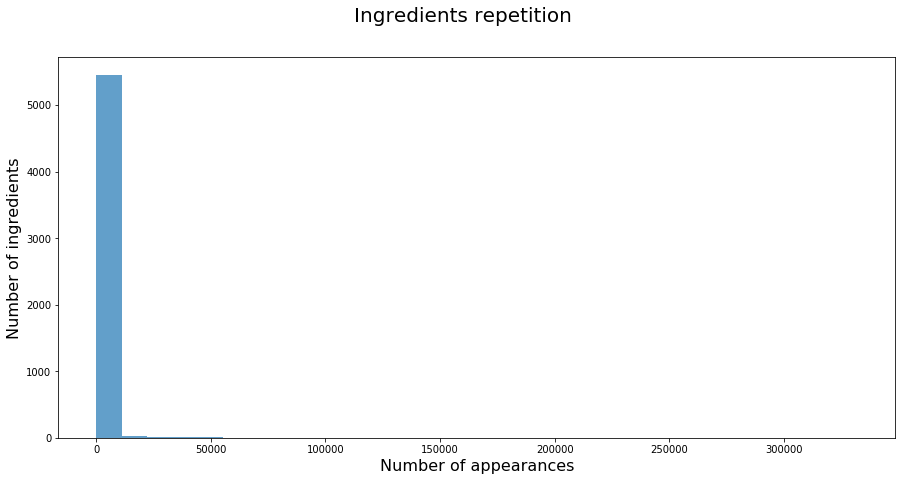

In [28]:
initial_time = time.time()
repetitionArray = []
mean = 0
for i in sorted_ingredients:
    repetitionArray.append(i[1])
    mean += i[1]
    
mean = mean/len(repetitionArray)
print(color.GREEN + "Number of total ingredients:", len(repetitionArray), color.END)
printMain("Average of appearances of the ingredients in recipes: " + str(round(mean, 2)) + " appearances.")
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle('Ingredients repetition', fontsize=20)
plt.xlabel('Number of appearances', fontsize=16)
plt.ylabel('Number of ingredients', fontsize=16)
ax.hist(repetitionArray,bins=30, alpha=0.7)
plt.show(fig)

In the above plot we can not really see how the distribution of the ingredients' appearances is, but we can know that the big majority of ingredients (> 160000, nearly 100%) appear in a low amount of recipes. 

Let's do the same analysis but with ingredients with more than 2000 appearances.

Ingredients in more than 2000 recipes:
Number of total ingredients: 261 
Average of appearances of the ingredients in recpies: 20511.25 appearances.


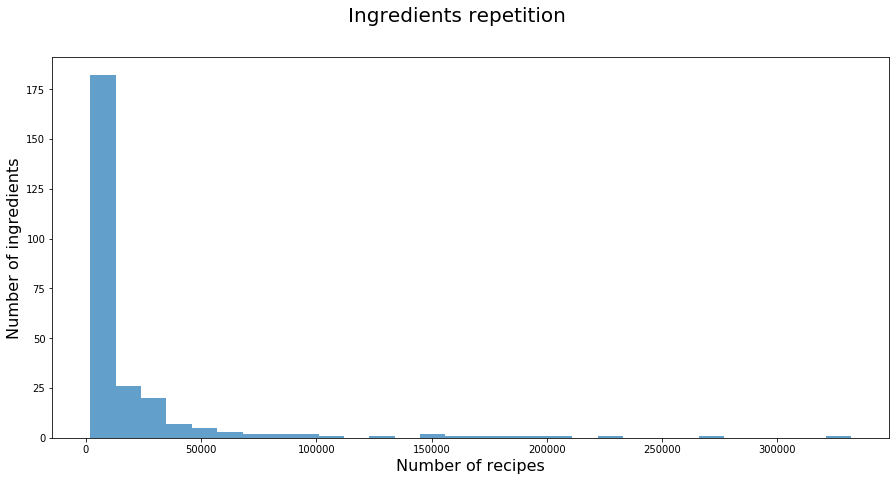

In [29]:
initial_time = time.time()
repetitionArray2 = []
mean2 = 0
for i in sorted_ingredients:
    if i[1] > 2000:
        mean += i[1]
        repetitionArray2.append(i[1])
        
mean = mean/len(repetitionArray2)
    
printMain("Ingredients in more than 2000 recipes:")
print(color.GREEN + "Number of total ingredients:", len(repetitionArray2), color.END)
printMain("Average of appearances of the ingredients in recpies: " + str(round(mean, 2)) + " appearances.")
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle('Ingredients repetition', fontsize=20)
plt.xlabel('Number of recipes', fontsize=16)
plt.ylabel('Number of ingredients', fontsize=16)
ax.hist(repetitionArray2, bins=30, alpha=0.7)
plt.show(fig)

Eventhough we have zoomed to avoid the ingredients repeated a few number of times, we still see that there are much more ingredients in the lower repetition part of the histogram. This shows us that we base our diet on a small amount of ingredients, depending a lot on them. This leads us into the next question:

### Are there dominant ingredients?

The answer is yes, but let's see which ones they are, and how dominant they are. For this, let's print a bar plot of the top 10 ingredients appearance.

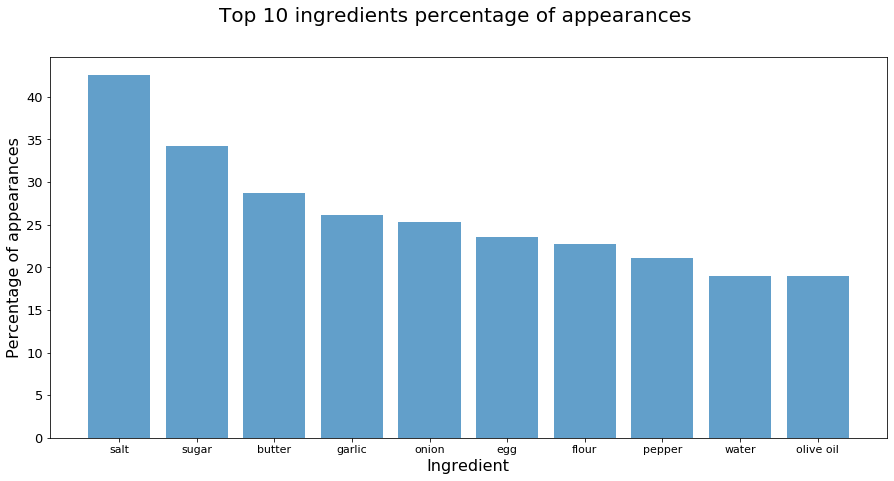

In [30]:
top10_ingredients = ingredients[:10]
top10_percentages = []

for i in repetitionArray2[:10]:
    top10_percentages.append(100*(i/len(df_ingredients)))
fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(np.arange(len(top10_percentages)), top10_percentages,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=top10_ingredients) 
fig.suptitle('Top 10 ingredients percentage of appearances', fontsize=20)
plt.ylabel('Percentage of appearances', fontsize=16)
plt.xlabel('Ingredient', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

We can see that there are ingredients really dominant in our diet nowadays. `Salt` and `Sugar` are present in close to 50% of the recipes. To see this with more perspective, let's get the average precentage of appearances:

In [31]:
printMain("Average percentage of appearances of ingredients in recipes: " + str(round(100*mean/len(df_ingredients), 2)) + "%")

Average percentage of appearances of ingredients in recipes: 2.62%


Once again we can see that there is a huge dominance of the top ingredients in the way we eat, confirming to us that the decision made of concentrating effort in the top 200 ingredients is, indeed, a good idea.

*Before the formatting of the ingredients' names with the aforementioned dictionary, the sugar was in the 3rd postion with a percentage of appearances of 30% (now it's above 40%). This is just an example of why the formatting was so important. In the case of the sugars, there were a lot of names for sugar, which is actually an important distinction for someone reading the recipe, but not for health, and, therefore, for us.*

### Are the most common ingredients healthy?

To answer this, let's get the unhealthy ingredients in the top 200 into a list and plot the top 10 (of the unhealthy) in a bar plot. 

In [32]:
df_unhealthy_ingredients = df_200_ingredients[df_200_ingredients["Unhealthy"] == 1]
unhealthy_ingredients = list(df_unhealthy_ingredients.index)
printMain("Top 10 unhealthy ingredients: ")
unhealthy_ingredients[:10]

Top 10 unhealthy ingredients: 


['sugar',
 'butter',
 'vegetable oil',
 'baking powder',
 'cream',
 'sour cream',
 'cream cheese',
 'cumin',
 'mayonnaise',
 'chocolate']

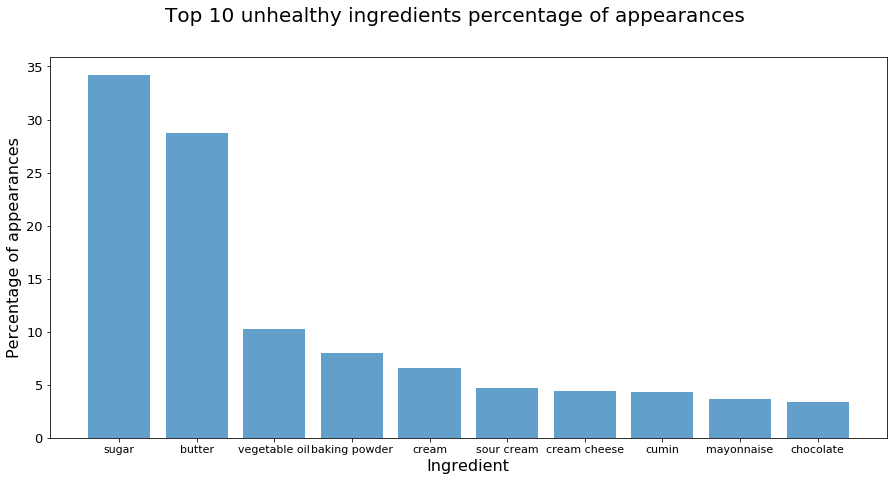

In [33]:
top10_percentages_unhealthy = []

for i in unhealthy_ingredients[:10]:
    top10_percentages_unhealthy.append(100*(dic_ingredients[i]/len(df_ingredients)))

fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(np.arange(10), top10_percentages_unhealthy,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=unhealthy_ingredients[:10]) 
fig.suptitle('Top 10 unhealthy ingredients percentage of appearances', fontsize=20)
plt.ylabel('Percentage of appearances', fontsize=16)
plt.xlabel('Ingredient', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

We can see that there are some really dominant ingredients that are unhealthy (especially `sugar` and `butter`). This is going to make a lot of recipes unhealthy.

**Important note:** We understand that it is also important to the "healthiness" of a recipe the quantity of these "unhealthy" ingredients in the recipes. There are two reasons why we do not take this into account. Firstly, given, the way the quantities are defined in the dataset, it's impossible to automate the reading of the values, as they are directly extracted form the real recipes in web pages. Secondly, we believe we can still make the analysis we try to do, as we make the assumption that in the big majority of recipes where unhealthy ingredients are used, they are used in a high enough quantity to consider them unhealthy. We assume that it is not common to use these unhealthy ingredients in such a low quantity that the meal created can be cataloged as healthy.

Let's finally see how this really affects the recipes. Let's catalogue recipes as healthy or unhealthy, depending on whether they contain unhealthy ingredients. Then, let's see what the percentage of unhealthy recipes is.

In [34]:
def isUnhealty(x):
    for i in x:
        if i in unhealthy_ingredients:
            return 1
    return 0
initial_time = time.time()
df_ingredients["Unhealthy"] = df_ingredients["ingredients"].apply(isUnhealty)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
df_ingredients.head()

(Time: 2.3 seconds)


,id,ingredients,Unhealthy
1,000033e39b,"[dry dill weed, mayonnaise, pimentos, american...",1
2,000035f7ed,"[basil, yellow bell pepper, tomatoes, onion, o...",0
3,00003a70b1,"[water, milk, mashed potatoes, french - fried ...",1
5,0000631d90,"[soy sauce, beef, salt and black pepper, lemon...",1
6,000075604a,"[chicken, pepper, tea]",0


In [35]:
printMain("Number of unhealthy recipes: " + str(len(df_ingredients[df_ingredients["Unhealthy"] == 1])))
printMain("Number of healthy recipes: " + str(len(df_ingredients[df_ingredients["Unhealthy"] == 0])))
printMain("Percentage of unhealthy recipes: " + str(round(len(df_ingredients[df_ingredients["Unhealthy"] == 1])/len(df_ingredients),2)) + "%")

Number of unhealthy recipes: 552644
Number of healthy recipes: 229000
Percentage of unhealthy recipes: 0.71%


We can see then that only ~30% of the recipes are healthy. This lead us into the next question.

### Is it easier or harder to eat healthy with the selected diets?

Let's mark the recipes as being approved for the different diets.

In [47]:
# LactoseFree recipes
initial_time = time.time()
lactose_ingredients = df_200_ingredients[df_200_ingredients["Lactose"] == 0]
lactose_ingredients = list(lactose_ingredients.index)
def isLactoseFree(x):
    for i in x:
        if i in lactose_ingredients:
            return 0
    return 1
df_ingredients["LactoseFree"] = df_ingredients["ingredients"].apply(isLactoseFree)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of gluten free recipes: " + str(len(df_ingredients[df_ingredients["LactoseFree"] == 1])))

(Time: 1.67 seconds)
Number of gluten free recipes: 356344


In [48]:
# GlutenFree recipes
initial_time = time.time()
gluten_ingredients = df_200_ingredients[df_200_ingredients["Gluten"] == 0]
gluten_ingredients = list(gluten_ingredients.index)
def isGlutenFree(x):
    for i in x:
        if i in gluten_ingredients:
            return 0
    return 1
df_ingredients["GlutenFree"] = df_ingredients["ingredients"].apply(isGlutenFree)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of gluten free recipes: " + str(len(df_ingredients[df_ingredients["GlutenFree"] == 1])))

(Time: 1.21 seconds)
Number of gluten free recipes: 559626


In [49]:
# Vegan recipes
initial_time = time.time()
vegan_ingredients_blacklist = df_200_ingredients[df_200_ingredients["Vegan"] == 0                                           ]
vegan_ingredients_blacklist = list(vegan_ingredients_blacklist.index)
def isVegan(x):
    for i in x:
        if i in vegan_ingredients_blacklist:
            return 0
    return 1
df_ingredients["Vegan"] = df_ingredients["ingredients"].apply(isVegan)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of vegan recipes: " + str(len(df_ingredients[df_ingredients["Vegan"] == 1])))

(Time: 1.85 seconds)
Number of vegan recipes: 219984


Now, let's plot the precentage of healthy recipes per type of diet.

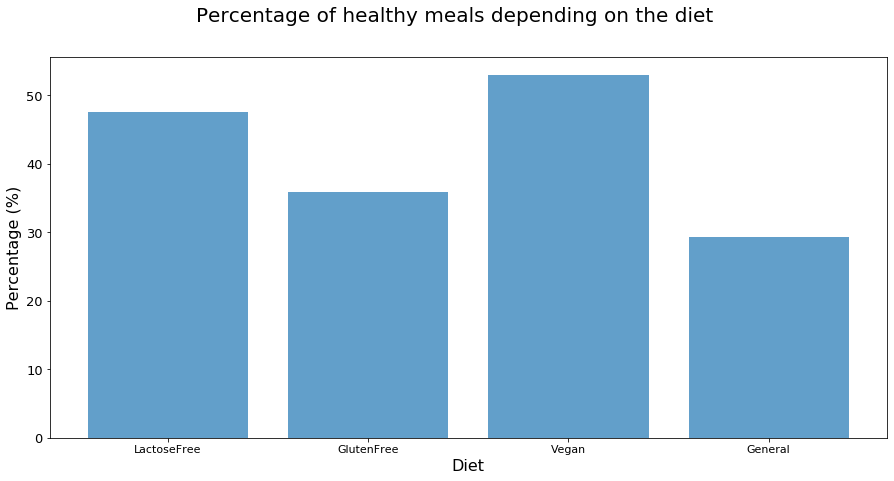

In [50]:
_data = []
_data.append(100*len(df_ingredients[(df_ingredients["LactoseFree"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["LactoseFree"] == 1]))
_data.append(100*len(df_ingredients[(df_ingredients["GlutenFree"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["GlutenFree"] == 1]))
_data.append(100*len(df_ingredients[(df_ingredients["Vegan"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["Vegan"] == 1]))
_data.append(100*len(df_ingredients[df_ingredients["Unhealthy"] == 0])/len(df_ingredients))
_keys = ["LactoseFree", "GlutenFree", "Vegan", "General"]
fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(np.arange(4), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Percentage of healthy meals depending on the diet', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=16)
plt.xlabel('Diet', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

We can see that there are changes in the results. Apparently, for a vegan, it's easier to avoid unhealthy food than for a person with a regular diet. Obviously, this is a simple approach, as we are not taking other things into account. However, it will help us a lot in the analysis for the next milestone.

### What is the distribution of the number of ingredients of recipes?

Let's add a new feature to the dataframe `df_ingredients`that has the amount of ingredients per recipe. Then, let's plot the distribution of values of this column.

In [51]:
initial_time = time.time()
df_ingredients['length'] = df_ingredients['ingredients'].apply(lambda x: len(x))
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("DataFrame with new column: ")
df_ingredients.head()

(Time: 0.34 seconds)
DataFrame with new column: 


,id,ingredients,Unhealthy,LactoseFree,GlutenFree,Vegan,length
1,000033e39b,"[dry dill weed, mayonnaise, pimentos, american...",1,0,0,0,9
2,000035f7ed,"[basil, yellow bell pepper, tomatoes, onion, o...",0,1,1,1,8
3,00003a70b1,"[water, milk, mashed potatoes, french - fried ...",1,0,1,0,7
5,0000631d90,"[soy sauce, beef, salt and black pepper, lemon...",1,1,1,0,10
6,000075604a,"[chicken, pepper, tea]",0,1,1,0,3


(Time: 0.08 seconds)


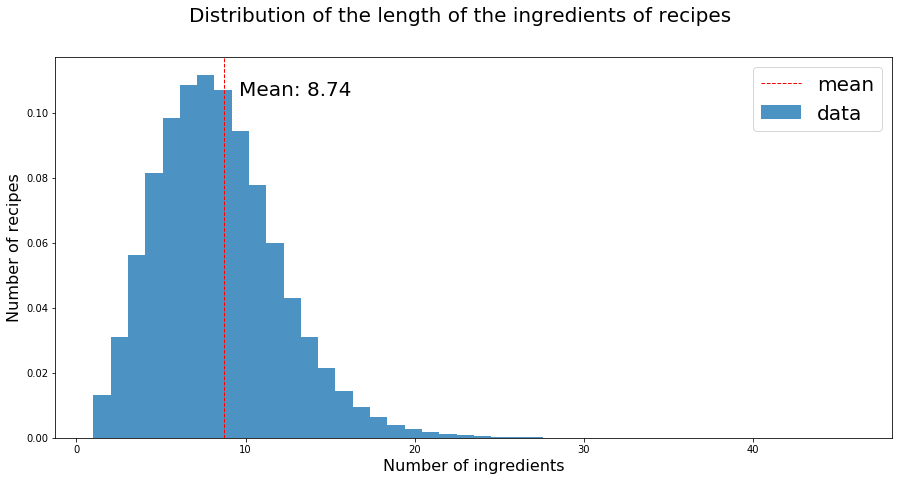

In [52]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients["length"]
_mean = df_ingredients["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of recipes', fontsize=16)
plt.hist(_data, density=True, bins=44, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
min_ylim, max_ylim = plt.ylim()
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

*In this analysis, we found some outliers with a large amount of ingredients (>100). We discovered the problem was that some ingredients were repeated in the list. We actually solve this in the formating of ingredients previously done 

### Does the distribution change when taking into account the diets?

Let's see.

(Time: 0.16 seconds)


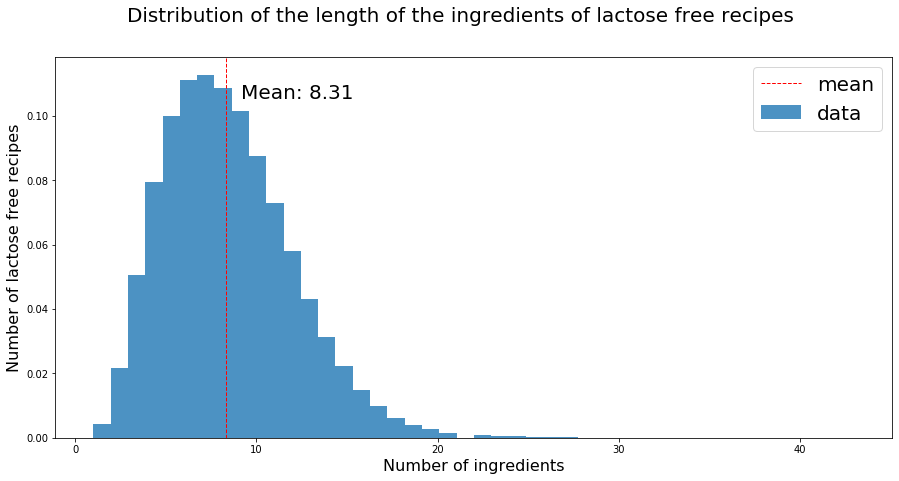

In [53]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["LactoseFree"] == 1]["length"]
_mean = df_ingredients[df_ingredients["LactoseFree"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of lactose free recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of lactose free recipes', fontsize=16)
plt.hist(_data, density=True, bins=44, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.21 seconds)


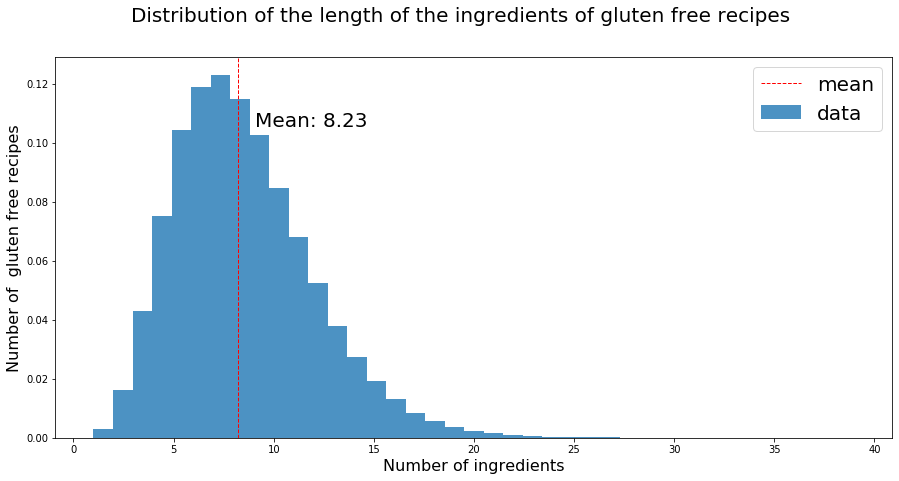

In [54]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["GlutenFree"] == 1]["length"]
_mean = df_ingredients[df_ingredients["GlutenFree"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of gluten free recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of  gluten free recipes', fontsize=16)
plt.hist(_data, density=True, bins=39, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.13 seconds)


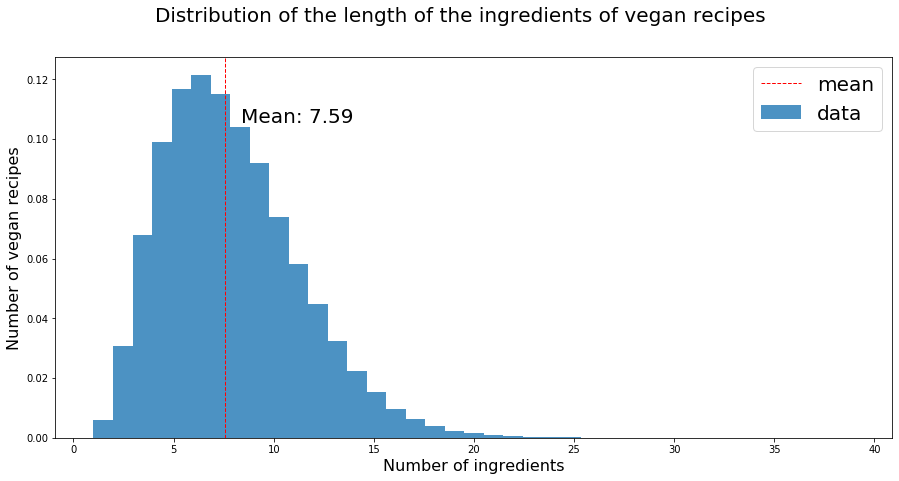

In [55]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["Vegan"] == 1]["length"]
_mean = df_ingredients[df_ingredients["Vegan"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of vegan recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of vegan recipes', fontsize=16)
plt.hist(_data, density=True, bins=39, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

We see there are small changes in the distributions in the different diets, but they are not significant.

## 4) Starting the core analysis

In this part we will start with the core analysis of the project. We will start only with a little part of it to ensure that the objectives of the second milestone have been achieved.

First we will create a correlation matrix in which each row and column are the top 200 ingredients and the cells are the percentage of shared recipes between the row ingredient and the column one.

In [56]:
# We want to find, for each ingredient, how often they occur together with another ingredient
initial_time = time.time()
occurrence_dict = {}
top_200_ingredients_list = list(df_200_ingredients.index)
for ingredient_list in df_ingredients["ingredients"]:
    for ingredient in ingredient_list:
        if ingredient not in top_200_ingredients_list:
            continue
        if ingredient not in occurrence_dict.keys():
            occurrence_dict[ingredient] = {}
        for other_ingredient in ingredient_list:
            if other_ingredient not in top_200_ingredients_list:
                continue
            # Iterate through each other ingredient in the recipe
            if other_ingredient not in occurrence_dict[ingredient].keys():
                occurrence_dict[ingredient][other_ingredient] = 0
            occurrence_dict[ingredient][other_ingredient] = occurrence_dict[ingredient][other_ingredient] + 1
print("(Time:", round(time.time() - initial_time, 2), "seconds)")


(Time: 87.35 seconds)


In [57]:
# We calculate the ratio at which two ingredients appear in the same recipe, for each ingredient
initial_time = time.time()
ratios_dict = {}
for ingredient in occurrence_dict.keys():
    occurrences = occurrence_dict[ingredient]
    ratios = occurrences.copy()
    for other_ingredient in occurrences:
        ratios[other_ingredient] = occurrences[other_ingredient] / occurrences[ingredient]
    ratios_dict[ingredient] = ratios

print("(Time:", round(time.time() - initial_time, 2), "seconds)")

(Time: 0.02 seconds)


In [58]:
initial_time = time.time()
df_ratios = pd.DataFrame(ratios_dict)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
df_ratios

(Time: 0.04 seconds)


,mayonnaise,vinegar,salt,celery,pasta,bell pepper,basil,tomatoes,onion,olive oil,...,creme fraiche,apple cider,mirin,peanuts,chickpeas,artichoke hearts,marshmallows,sun - dried tomatoes,prepared horseradish,poppy seeds
mayonnaise,1.000000,0.062390,0.030821,0.115641,0.039707,0.049314,0.030540,0.041400,0.043500,0.020110,...,0.033163,0.007740,0.030028,0.016801,0.012529,0.207555,0.013090,0.032343,0.241424,0.052713
vinegar,0.157461,1.000000,0.108017,0.143404,0.059835,0.164799,0.150932,0.144991,0.131450,0.184580,...,0.075680,0.131966,0.201106,0.129506,0.110937,0.105263,0.007448,0.130693,0.169811,0.193921
salt,0.362439,0.503290,1.000000,0.483777,0.418939,0.431105,0.470076,0.469089,0.490982,0.500629,...,0.443878,0.377322,0.227973,0.290865,0.509005,0.322156,0.181675,0.402640,0.465266,0.566756
celery,0.173146,0.085077,0.061598,1.000000,0.090576,0.157681,0.083262,0.109804,0.154891,0.066877,...,0.047619,0.050697,0.012248,0.036052,0.078048,0.045416,0.007899,0.042904,0.121784,0.031935
pasta,0.015367,0.009175,0.013788,0.023412,1.000000,0.027492,0.047337,0.033452,0.021934,0.027692,...,0.010204,0.000774,0.002766,0.008400,0.016184,0.017827,0.000903,0.041584,0.003002,0.007695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dark chocolate,0.000106,0.000393,0.002198,0.000142,NaN,0.000207,0.000107,0.000308,0.000212,0.000352,...,0.008078,NaN,NaN,0.004900,NaN,NaN,0.009253,NaN,NaN,0.000770
almond extract,0.000177,0.000954,0.010707,0.000047,NaN,0.000034,0.000134,0.000012,0.000025,0.000345,...,0.002976,0.003096,NaN,0.001750,0.000261,NaN,0.007222,NaN,NaN,0.048095
pumpkin pie spice,0.000106,0.000575,0.004191,0.000213,0.000366,0.000259,0.000027,0.000172,0.000314,0.000345,...,0.000850,0.019350,NaN,0.000350,0.000783,NaN,0.006545,NaN,0.000429,NaN
graham cracker crumbs,0.000035,0.000267,0.002020,0.000024,NaN,NaN,0.000027,0.000025,0.000035,0.000020,...,0.005102,NaN,NaN,0.016451,NaN,NaN,0.040849,NaN,NaN,0.003463


With this we can see that actually yes, with the data that we have we can do the analysis we want to do. If we print the same matrix as above but with only the top ten ingredients we will see the conclusion better. This is not useful for the future analysis, but it is for viewing the results.

In [59]:
top_200_ingredients_list.remove("dijon mustard")
top_200_ingredients_list.remove("granny smith apples")

In [60]:
df_ratios = df_ratios.drop(columns=top_200_ingredients_list[10:])
df_ratios = df_ratios.drop(top_200_ingredients_list[10:])

,salt,onion,olive oil,water,butter,pepper,sugar,garlic,egg,flour
salt,1.000000,0.490982,0.500629,0.483868,0.516370,0.789603,0.502374,0.480358,0.578759,0.678072
olive oil,0.222857,0.299521,1.000000,0.143956,0.093443,0.334716,0.058958,0.411842,0.078304,0.086361
garlic,0.295695,0.499120,0.569509,0.241516,0.165392,0.475187,0.110403,1.000000,0.108800,0.114979
egg,0.319901,0.139016,0.097228,0.202611,0.400941,0.162777,0.413586,0.097694,1.000000,0.557923
water,0.216304,0.201096,0.144564,1.000000,0.164071,0.170198,0.235154,0.175391,0.163864,0.228658
flour,0.362571,0.132719,0.103735,0.273504,0.461140,0.154586,0.429245,0.099875,0.539727,1.000000
pepper,0.392134,0.379874,0.373415,0.189079,0.182187,1.000000,0.091036,0.383364,0.146252,0.143575
onion,0.292316,1.000000,0.400594,0.267826,0.189991,0.455409,0.111268,0.482740,0.149738,0.147776
sugar,0.403895,0.150253,0.106481,0.422916,0.517211,0.147377,1.000000,0.144193,0.601573,0.645399
butter,0.349479,0.215976,0.142068,0.248400,1.000000,0.248286,0.435398,0.181843,0.490932,0.583681


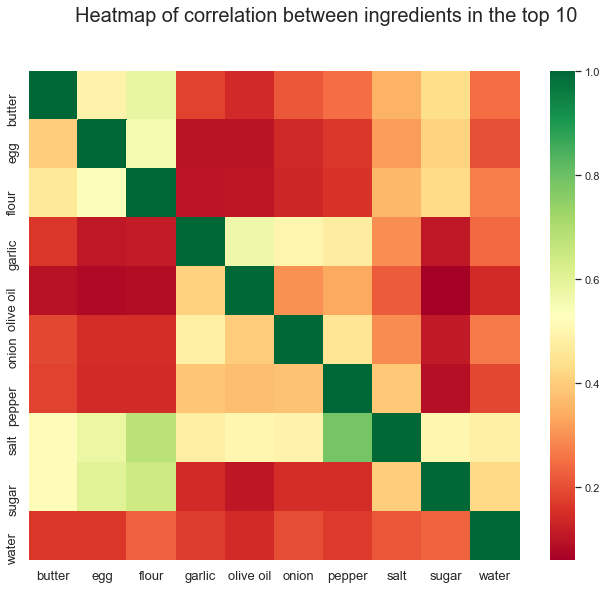

In [61]:
import seaborn as sns
sns.set()
plt.figure(figsize = (11,9))
df_ratios = df_ratios.sort_index(ascending=True)
df_ratios = df_ratios.sort_index(ascending=True, axis=1)
plt.suptitle('Heatmap of correlation between ingredients in the top 10', fontsize=20)
ax = sns.heatmap(df_ratios, cmap="RdYlGn")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_ylim(10, 0)
plt.show()

*The heat map is not symmetric because the ratio of, for example, egg in the recipes with butter is not the same as the ratio of butter in recipes with egg* 

---

# Conclusions and next steps

In this last plot we can actually see that the data is giving us what we expected! We can see nicely how ingredients correlate with each other in the recipes and from this we can do the analysis we want to do. Before ending the part of the notebook related to analysis of the recipe dataset, we resume the goals we want to achive in the future milestones, and also mention some flaws we see in our project (related to the recipes analysis).

### Goals

- Investigate in depth how the various dietary restrictions affect your general diet.
- Discover interesting relationships between different ingredients.
- Answer all the questions posed in the introduction.

### Flaws:

- We don't take into account the amount of each ingredient in the recipes. 
- We don't take into account how much a specific recipe is used.
- We focus on the amount of recipes that contain certain ingredients, but the fact that an ingredient is included in many recipes does not necessarily imply that we eat a high amount of that ingredient. The inverse is also true - even though an ingredient may appear in fewer recipes, these recipes may be so commonly used, and the quantity of the ingredients used so high, that this results in a high consumption of this ingredient in the population. 